In [2]:
import os, sys
import xarray as xr
import numpy as np
import pandas as pd
import random
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
from datetime import datetime
import matplotlib.patches as mpatches
from skimage.io import imread
from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde
from sklearn.decomposition import PCA

import matplotlib.patheffects as pe
from matplotlib.colors import Normalize
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 15})

In [3]:
DATA_PATH = '../data/converted/'

site_lats = [46.532, 44.908, 61.845, 47.97, 59.81, 67.84, 37.665, 42.686, 71.323, 44.232]
site_lons = [-87.548, -84.719, 24.287, -123.58, 7.21, 20.41, 128.7, -73.823, -156.612, -79.781]
site_name_offsets_y = [4, -6, 3.5, 1.5, 0, 0.75, -4, -6, 2.5, 2.5]
site_name_offsets_x = [-7, -7, 5, -7, -15, -17, 8, -2, 2.5, 1.5]
names = ['MQT', 'APX', 'FIN', 'OLY', 'HAK', 'KIS', 'ICP', 'IMP', 'NSA', 'GCP']
colors = ['black', 'r', 'g', 'b', 'orange', 'c', 'm', 'gold', 'pink', 'purple']


Site ID: MQT
Total files processed: 2162
Total non-NaN entries: 283222
Total entries including NaN: 3113280
------
Site ID: distributions
Total files processed: 0
Total non-NaN entries: 0
Total entries including NaN: 0
------
Site ID: FIN
Total files processed: 1877
Total non-NaN entries: 245887
Total entries including NaN: 2702880
------
Site ID: IMP
Total files processed: 95
Total non-NaN entries: 12445
Total entries including NaN: 136800
------
Site ID: HAUK
Total files processed: 63
Total non-NaN entries: 8253
Total entries including NaN: 90720
------
Site ID: APX
Total files processed: 99
Total non-NaN entries: 12969
Total entries including NaN: 142560
------
Site ID: KIS
Total files processed: 166
Total non-NaN entries: 21746
Total entries including NaN: 239040
------
Site ID: NSA
Total files processed: 286
Total non-NaN entries: 37466
Total entries including NaN: 411840
------
Site ID: KO2
Total files processed: 27
Total non-NaN entries: 3537
Total entries including NaN: 38880
-

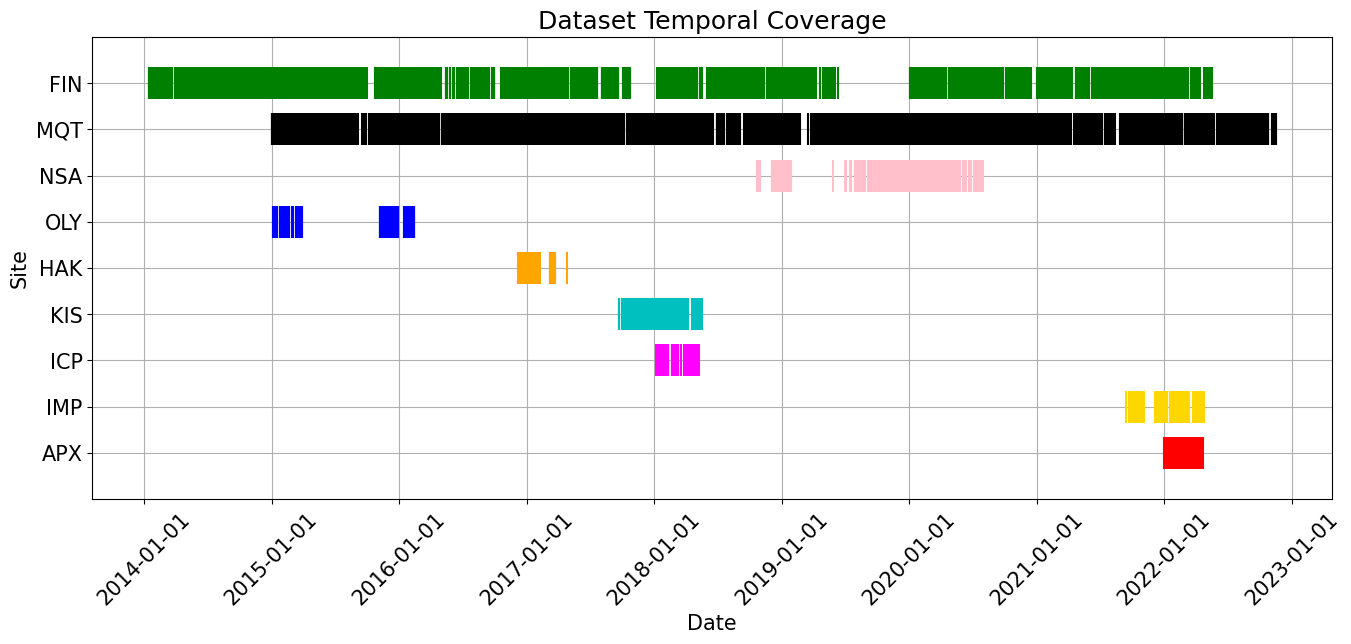

In [11]:
def calc_totals_for_tables():
    # Initialize a dictionary to store the results
    site_totals = {}
    site_dates = {}

    # Loop through all subfolders in the DATA_PATH directory
    for subdir, _, _ in os.walk(DATA_PATH):
        # Extract the site ID from the folder name
        folder_name = os.path.basename(subdir)
        year_site_split = folder_name.split('_')
        if len(year_site_split) == 2:
            year, site_id = year_site_split

            # Initialize site info if not already present
            if site_id not in site_totals:
                site_totals[site_id] = {'total_files': 0, 'total_non_nan': 0, 'total_with_nan': 0}

            # Construct the path to the netCDF files
            netcdf_path = os.path.join(subdir, "netCDF/edensity_distributions")

            # If the folder exists, proceed
            if os.path.exists(netcdf_path):
                # Loop through all .nc files in the netcdf_path
                for filename in os.listdir(netcdf_path):
                    if filename.endswith(".nc"):
                        site_totals[site_id]['total_files'] += 1
                        file_path = os.path.join(netcdf_path, filename)

                        # Open the netCDF file using xarray
                        with xr.open_dataset(file_path) as ds:
                            # Extract the 'rho' variable
                            rho = ds['rho'].values  # This assumes 'rho' is present in the file

                            # Count non-NaN entries along the x-dimension where at least one y value in the column is non-NaN
                            non_nan_count = np.sum([1 for column in rho.T if not np.all(np.isnan(column))])
                            site_totals[site_id]['total_non_nan'] += non_nan_count

                            # Count total entries including NaN
                            site_totals[site_id]['total_with_nan'] += 1440

                            # Keep track of dates for plotting later
                            date_str = filename.split('_')[0]  # Modify this to suit how the date is stored
                            if site_id not in site_dates:
                                site_dates[site_id] = []
                            if non_nan_count > 0:
                                site_dates[site_id].append(date_str[3:11])

    # del site_dates['NSA']
    site_dates['OLY'] = site_dates['HUR']
    del site_dates['HUR']
    site_dates['HAK'] = site_dates['HAUK']
    del site_dates['HAUK']

    concatenated_subarray = site_dates['KO1'] + site_dates['KO2']
    site_dates['ICP'] = concatenated_subarray

    del site_dates['KO1']
    del site_dates['KO2']

    # Print the results
    for site_id, stats in site_totals.items():
        print(f"Site ID: {site_id}")
        print(f"Total files processed: {stats['total_files']}")
        print(f"Total non-NaN entries: {stats['total_non_nan']}")
        print(f"Total entries including NaN: {stats['total_with_nan']}")
        print("------")

    def plot_gantt():
        colors_temp = ['r', 'g', 'orange', 'magenta', 'gold', 'c', 'black', 'pink', 'b']
        sites_reordered =['APX', 'IMP', 'ICP', 'KIS', 'HAK', 'OLY', 'NSA', 'MQT', 'FIN']  
        colors_reordered = ['r', 'gold', 'magenta', 'c', 'orange', 'b', 'pink', 'black', 'g']
        
        # Initialize the figure
        fig, ax = plt.subplots(figsize=(16,6))
        ax.set_axisbelow(True)
        # Sort site_dates keys alphabetically
        sorted_keys = sorted(site_dates.keys())
        plt.grid()
        # Plot the data
        for i, site_id in enumerate(sites_reordered):
            dates = site_dates[site_id]
            dates_datetime = [datetime.strptime(date, '%Y%m%d') for date in dates]
            ax.scatter(dates_datetime, [i]*len(dates_datetime), marker='|', s=550, color=colors_reordered[i], label=site_id)

        # Format the plot
        ax.yaxis.set_ticks(range(len(sites_reordered)))
        ax.yaxis.set_ticklabels(sites_reordered)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.xticks(rotation=45)
        plt.ylim(-1, 9)  # Modify the upper limit according to your number of sites
        ax.set_xlabel('Date')
        ax.set_ylabel('Site')
        ax.set_title('Dataset Temporal Coverage')
        # plt.legend()
        plt.show()


    ############ RUN
    plot_gantt()

############ RUN
# calc_totals_for_tables()



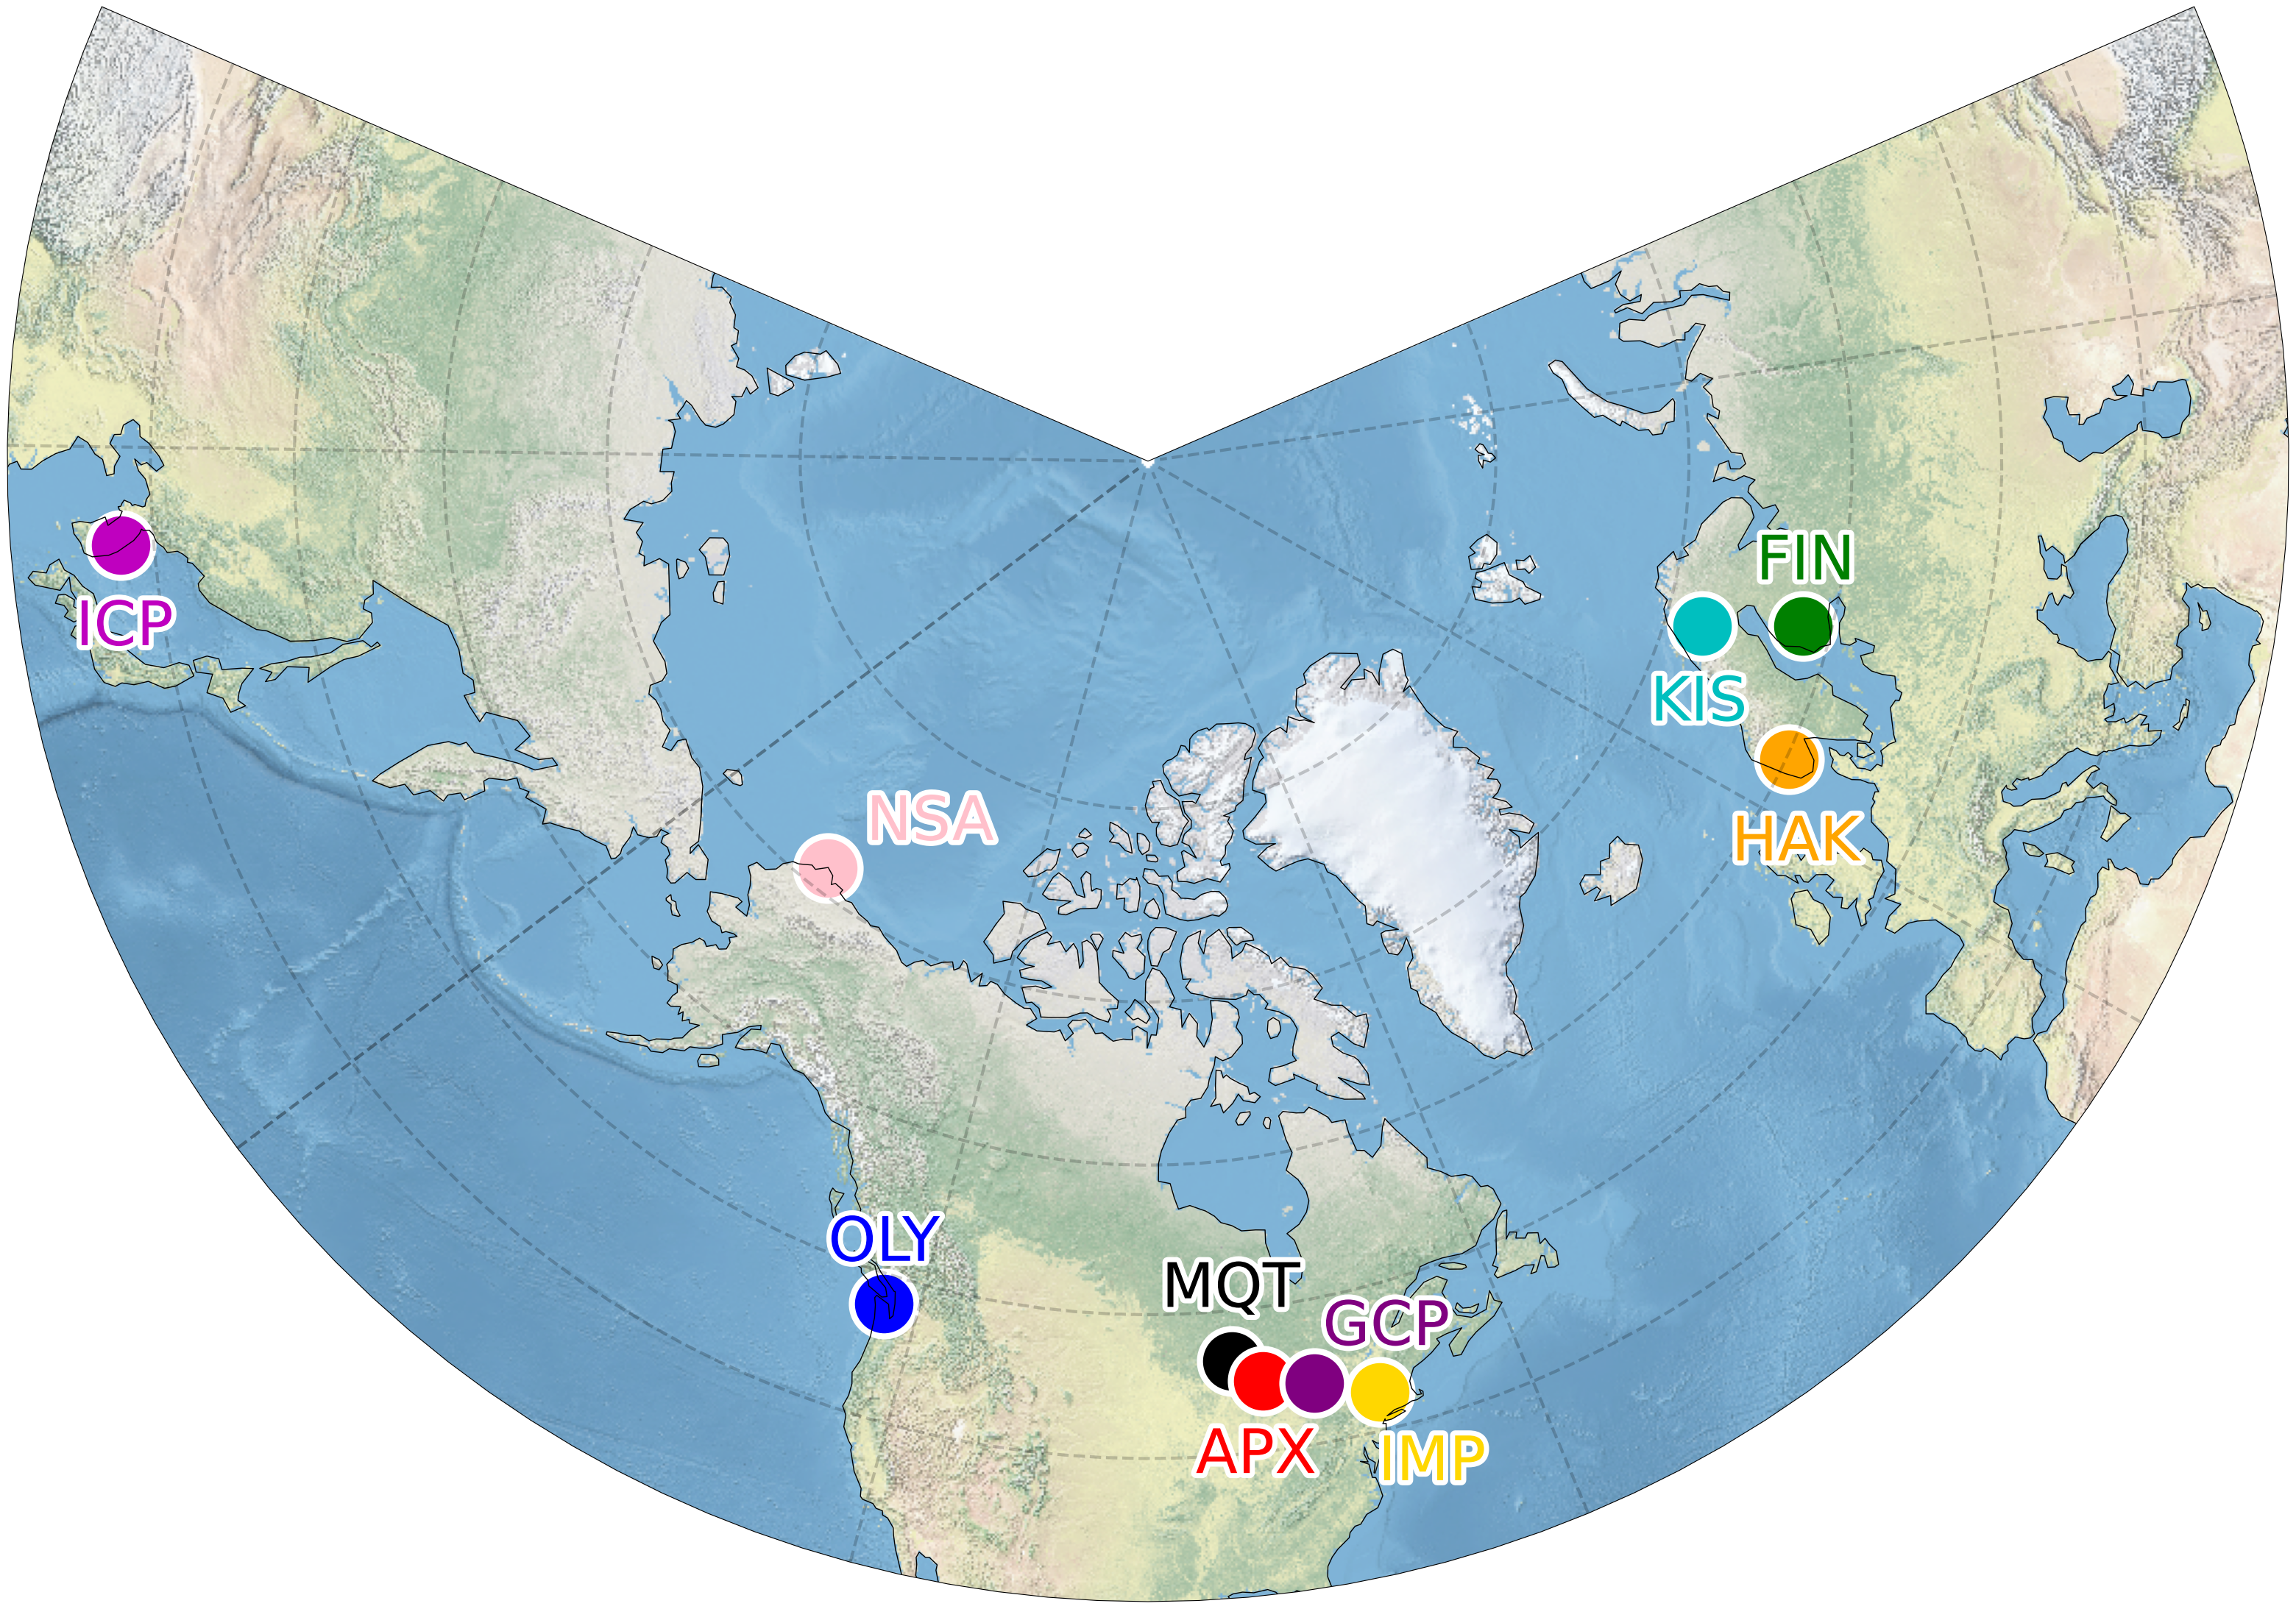

In [4]:

def plot_map():
    plt.figure(figsize=(40, 40))
    ax = plt.axes(projection=ccrs.LambertConformal(cutoff=30))

    fname = os.path.join('/Users/fraserking/Development/global_ml/NE1_50M_SR_W', 'NE1_50M_SR_W.tif')
    ax.imshow(imread(fname), origin='upper', transform=ccrs.PlateCarree())

    for i, lat in enumerate(site_lats):
        plt.scatter(site_lons[i], lat, color=colors[i], marker='o', edgecolors=['white'], linewidth=6, s=4000, transform=ccrs.Geodetic())
        plt.text(site_lons[i] + site_name_offsets_x[i], lat + site_name_offsets_y[i], names[i], fontsize=60, color=colors[i], path_effects=[pe.withStroke(linewidth=10, foreground="white")], transform=ccrs.Geodetic())  # adjust text position as needed
        
    ax.coastlines(resolution='110m')
    ax.gridlines(linewidth=3, color='black', linestyle='--', alpha=0.2)

    plt.show()

############ RUN
# plot_map()

Working on MQT


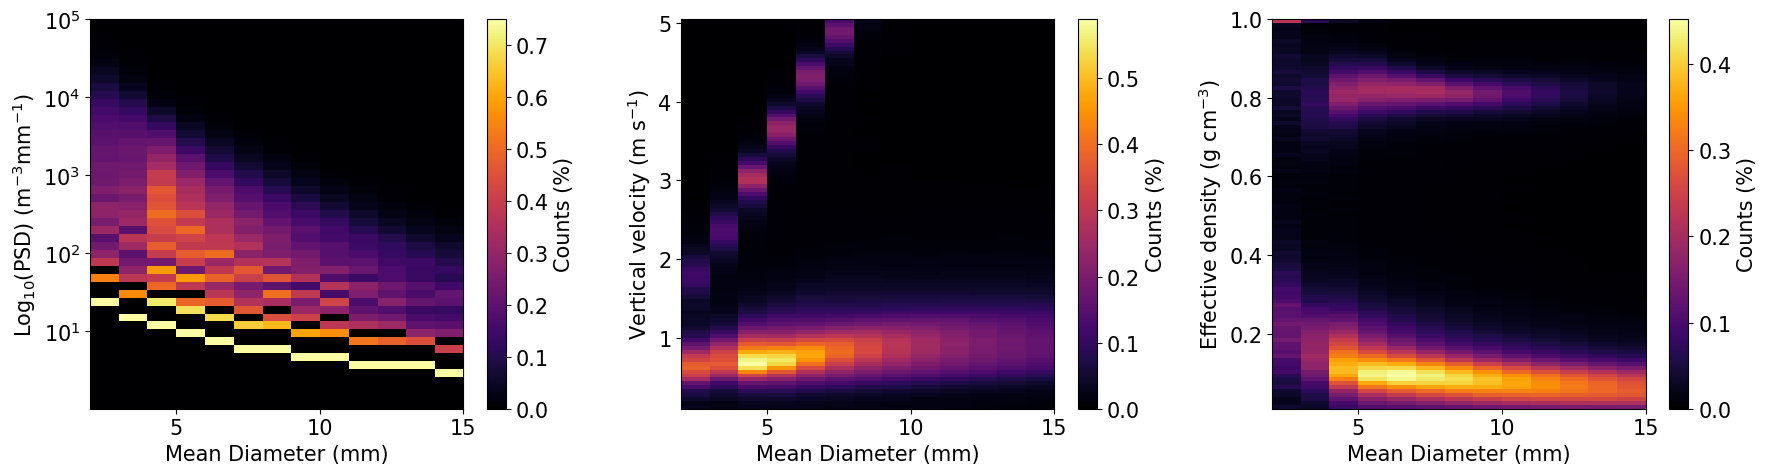

Working on APX


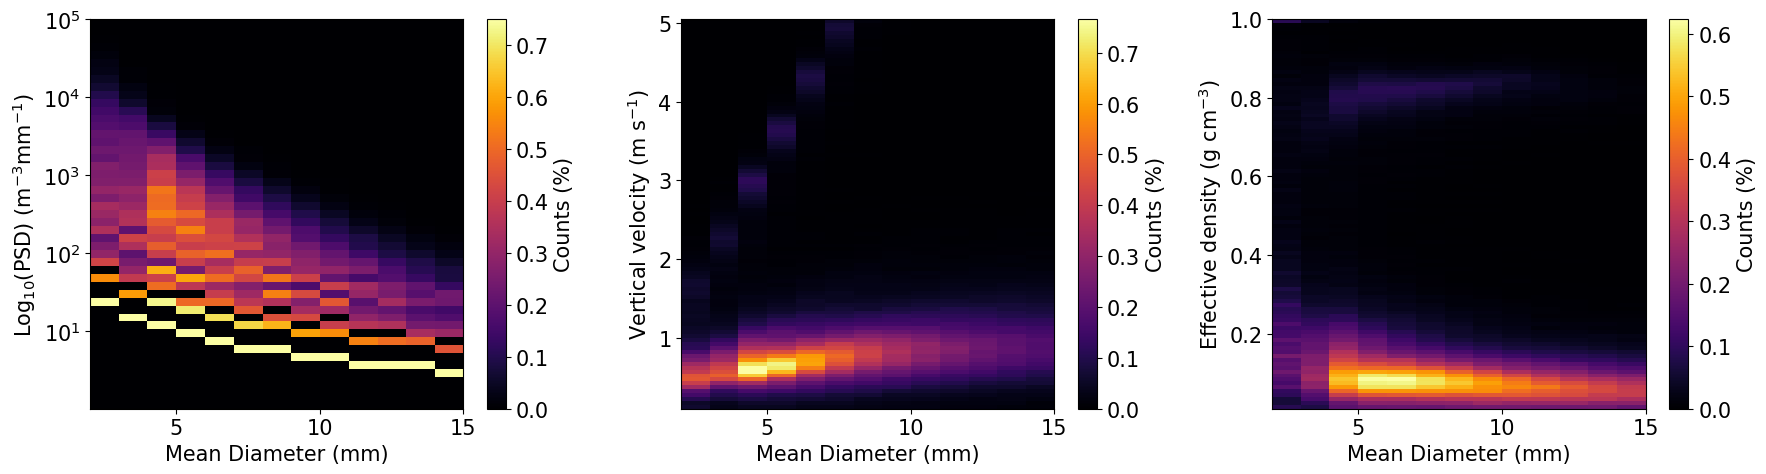

Working on FIN


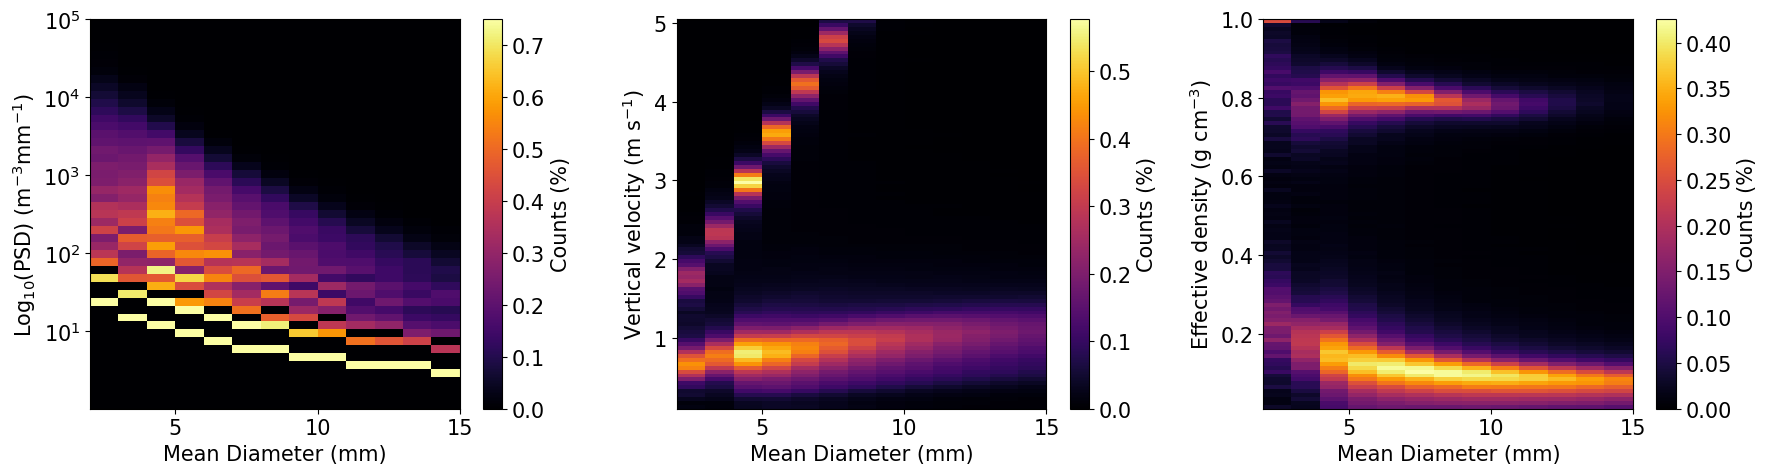

Working on HUR


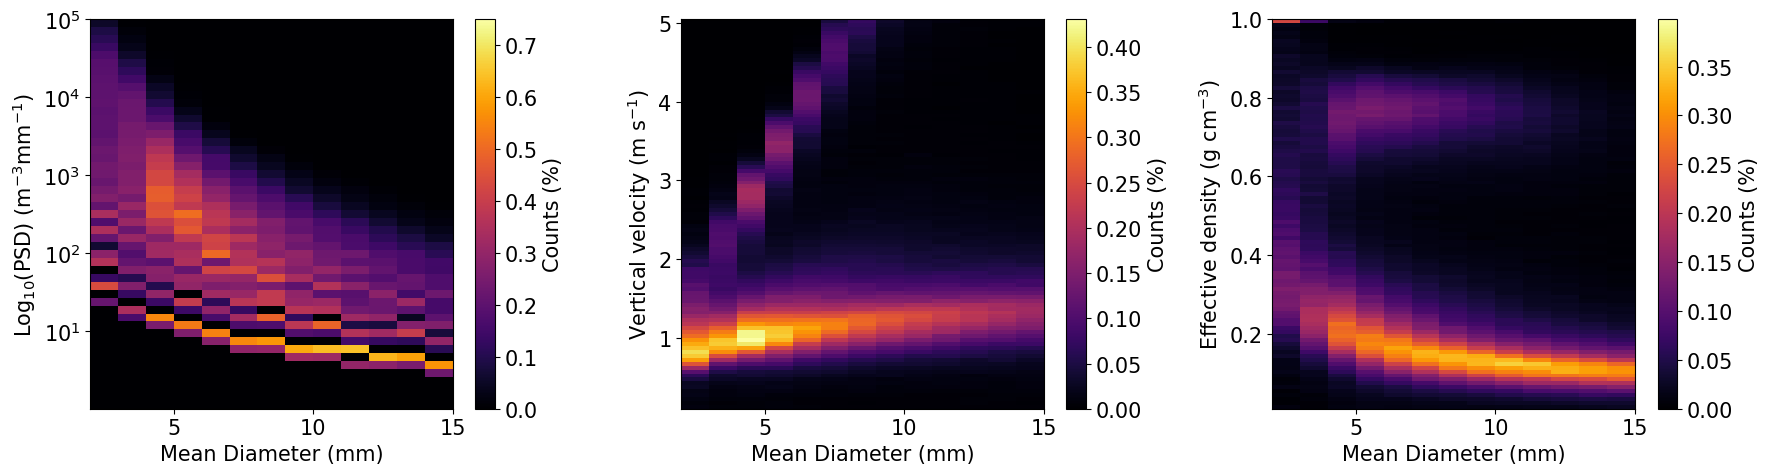

Working on HAUK


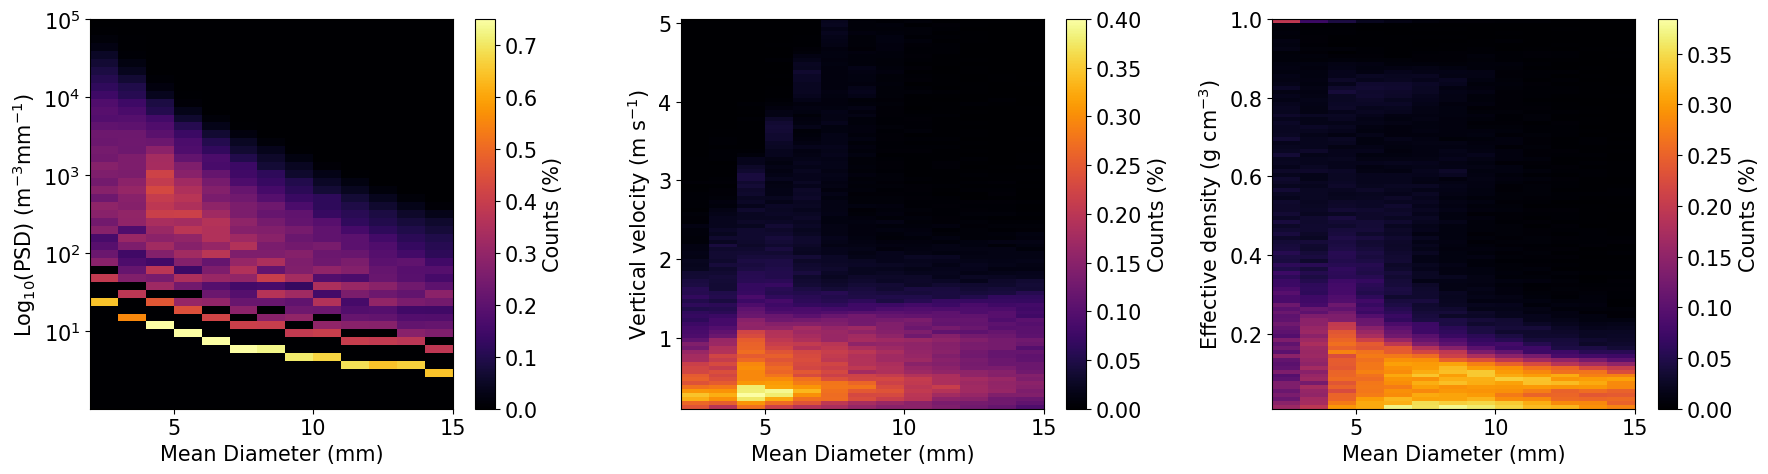

Working on KIS


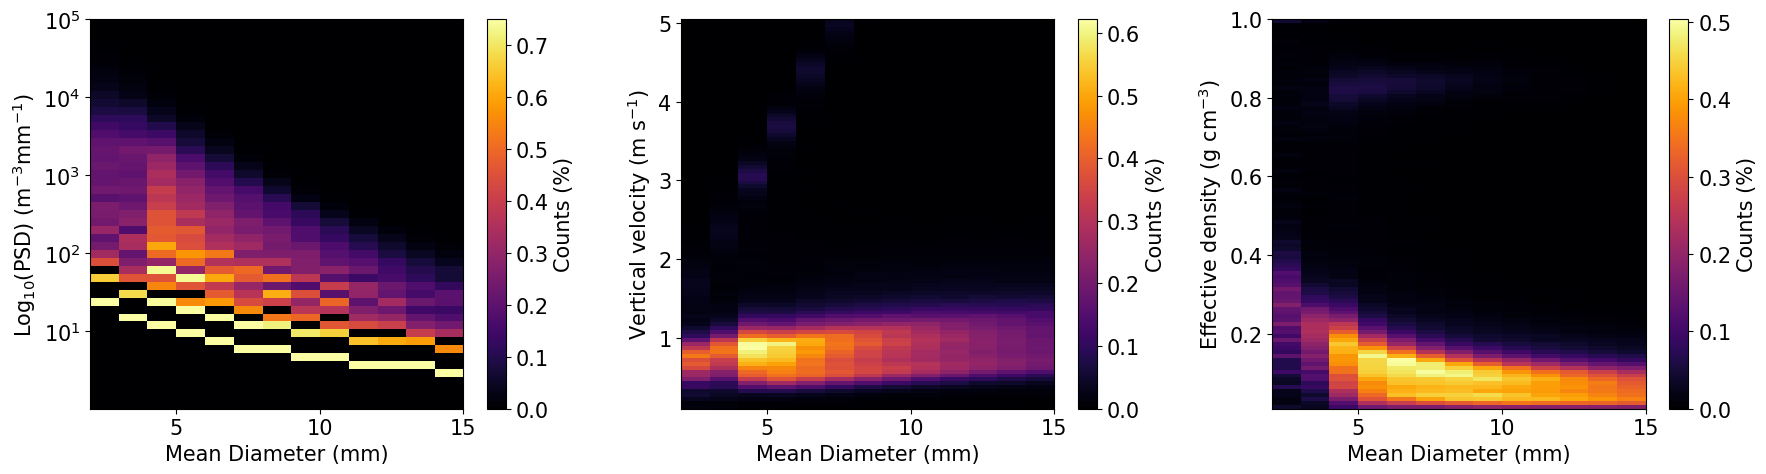

Working on KO1


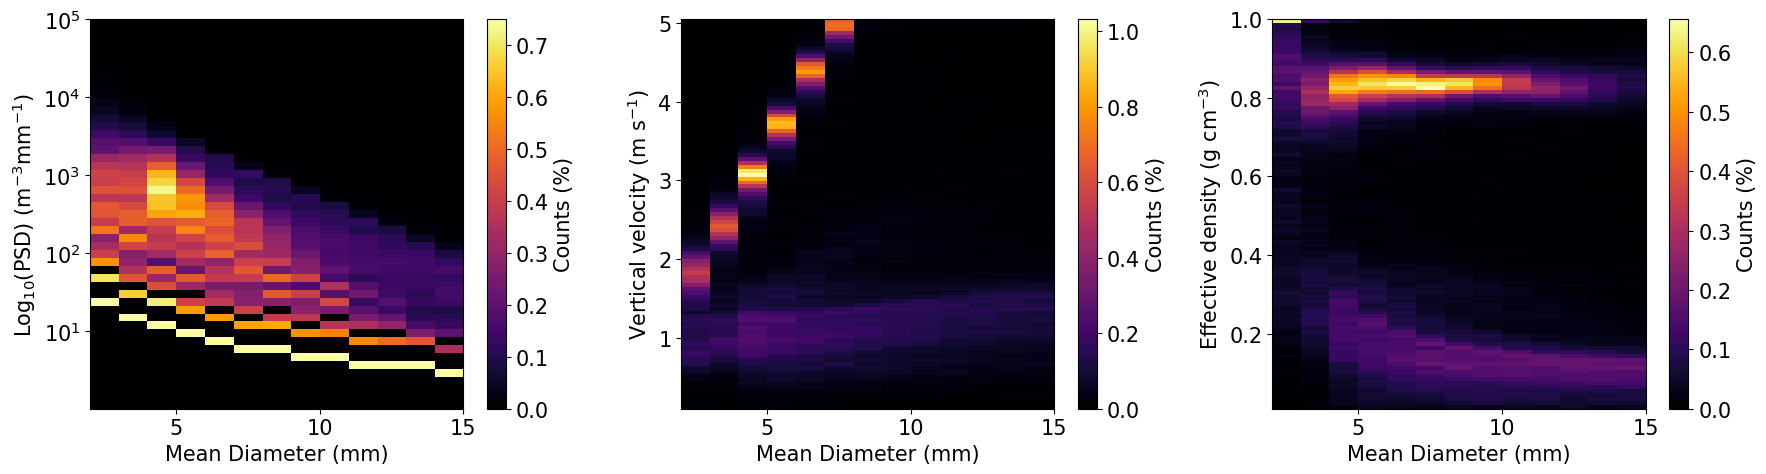

Working on KO2


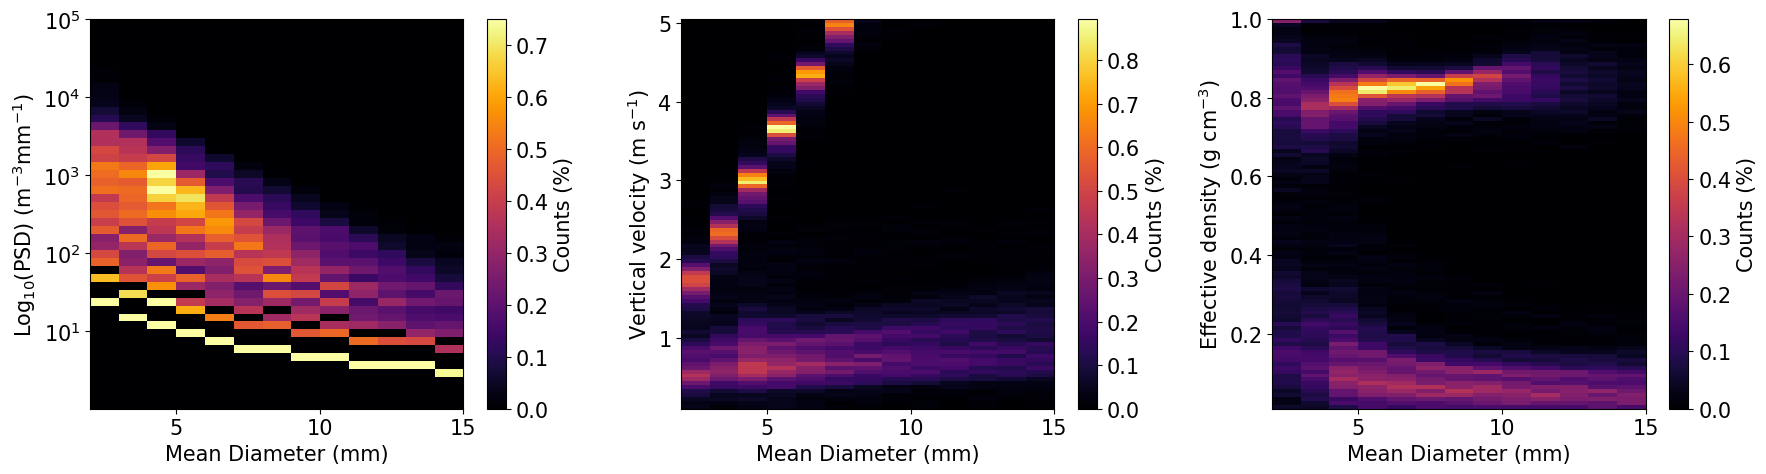

Working on IMP


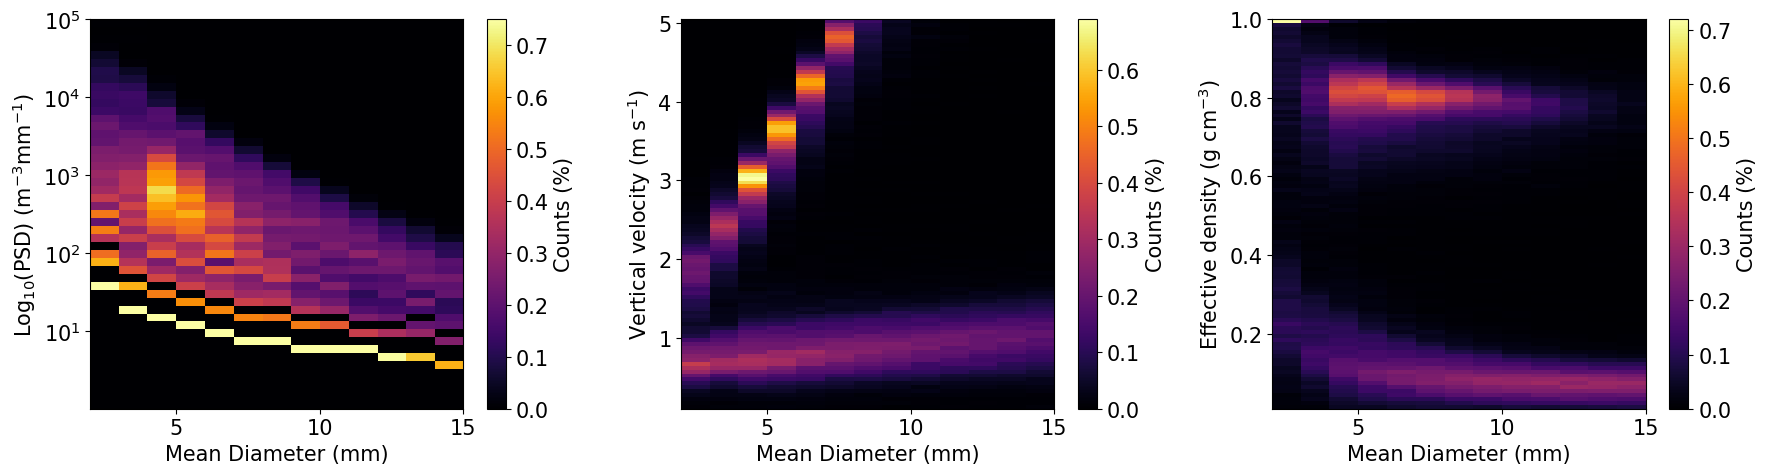

Working on NSA


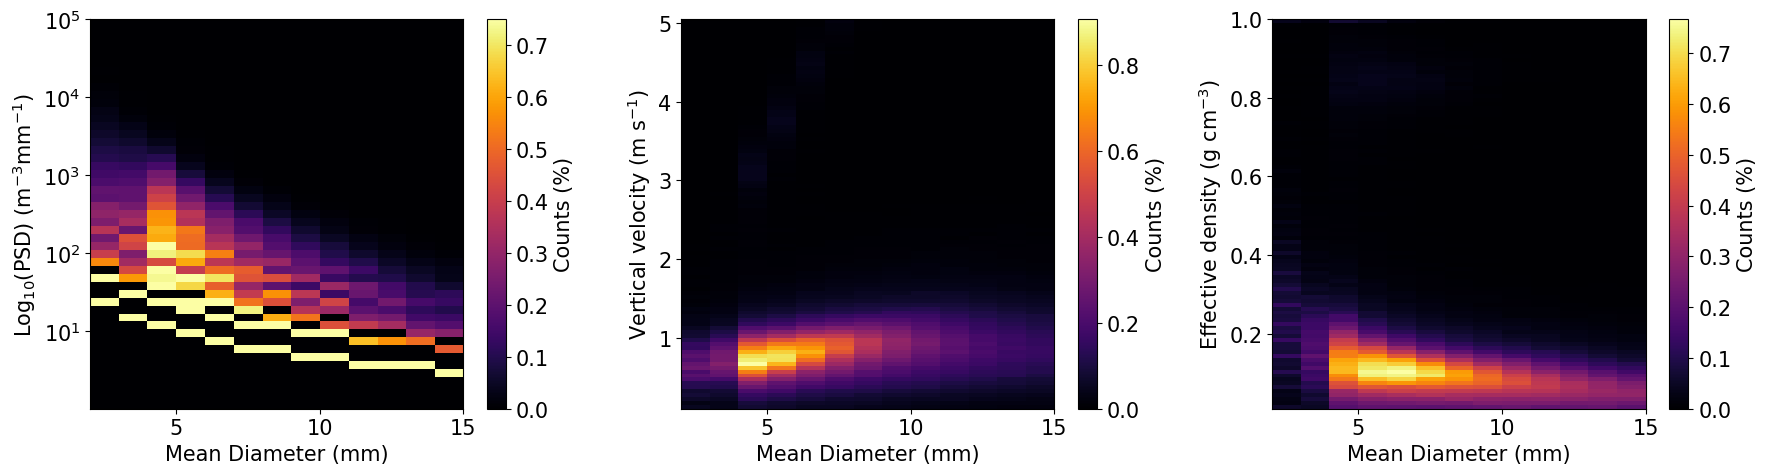

In [14]:
def create_hists_for_sites():

    names = ['MQT', 'APX', 'FIN', 'HUR', 'HAUK', 'KIS', 'KO1', 'KO2', 'IMP', 'NSA']
    base_folder = '/Users/fraserking/Development/pip_processing/data/converted'

    cmap = plt.get_cmap('inferno')
    cmap.set_bad(color='black')

    for site_name in names:
        print(f"Working on {site_name}")
        
        dsd_list = []
        dsd_height_list = []
        vvd_list = []
        vvd_height_list = []
        rho_list = []
        rho_height_list = []

        subdirs = [d for d in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, d))]
        matching_subdirs = [d for d in subdirs if site_name in d]
        
        for subdir in matching_subdirs:
            full_path = os.path.join(base_folder, subdir)
            # print(f"Processing subdirectory: {full_path}")

            pip_vars = ['netCDF/particle_size_distributions', 'netCDF/edensity_distributions', 'netCDF/velocity_distributions']
            for i,var in enumerate(pip_vars):
                netcdf_path = os.path.join(full_path, var)
                if os.path.exists(netcdf_path):
                    all_files = os.listdir(netcdf_path)
                    nc_files = [f for f in all_files if f.endswith('.nc')]
                    
                    for nc_file in nc_files:
                        # if site_name == 'NSA' and nc_file in bad_nsa_days:
                        #     print("BAD NSA DAY SKIPPING", nc_file)
                        #     continue

                        nc_file_path = os.path.join(netcdf_path, nc_file)
                        # print(f"Processing file: {nc_file_path}")
                        ds_pip = xr.open_dataset(nc_file_path)   

                        if i == 0:
                            dsd = ds_pip['psd'].values
                            dsd_height = np.repeat(np.arange(1, 132), dsd.shape[0])
                            dsd_list.append(dsd.T.flatten())
                            dsd_height_list.append(dsd_height)
                        elif i == 1:
                            rho = ds_pip['rho'].values
                            rho_height = np.repeat(np.arange(1, 132), rho.shape[0])
                            rho_list.append(rho.T.flatten())
                            rho_height_list.append(rho_height)
                        elif i == 2:
                            vvd = ds_pip['vvd'].values
                            vvd_height = np.repeat(np.arange(1, 132), vvd.shape[0])
                            vvd_list.append(vvd.T.flatten())
                            vvd_height_list.append(vvd_height)



        dsd_ds = np.concatenate(dsd_list)
        dsd_height_ds = np.concatenate(dsd_height_list)
        vvd_ds = np.concatenate(vvd_list)
        vvd_height_ds = np.concatenate(vvd_height_list)
        rho_ds = np.concatenate(rho_list)
        rho_height_ds = np.concatenate(rho_height_list)

        bin_DSD = np.linspace(.001,5,50) #54
        bin_VVD = np.arange(0.1,5.1,0.05)
        bin_eden = np.arange(0.01,1.01,0.01)    
        bin_D = np.arange(0,26,1)
        
        dsd_x = np.asarray(dsd_ds).flatten()
        dsd_y = np.asarray(dsd_height_ds).flatten()
        dsd_x[dsd_x<=0] = np.nan
        mask = ~np.isnan(dsd_x)
        dsd_x = dsd_x[mask]
        dsd_y = dsd_y[mask]
        dsd_hist, dsd_xedges, dsd_yedges = np.histogram2d(dsd_y, np.ma.log10(dsd_x), (bin_D, bin_DSD))

        vvd_x = np.asarray(vvd_ds).flatten()
        vvd_y = np.asarray(vvd_height_ds).flatten()
        vvd_x[vvd_x<=0] = np.nan
        mask = ~np.isnan(vvd_x)
        vvd_x = vvd_x[mask]
        vvd_y = vvd_y[mask]
        vvd_hist, vvd_xedges, vvd_yedges = np.histogram2d(vvd_y, vvd_x, (bin_D, bin_VVD))
        
        rho_x = np.asarray(rho_ds).flatten()
        rho_y = np.asarray(rho_height_ds).flatten()
        rho_x[rho_x<=0] = np.nan
        mask = ~np.isnan(rho_x)
        rho_x = rho_x[mask]
        rho_y = rho_y[mask]
        rho_hist, rho_xedges, rho_yedges = np.histogram2d(rho_y, rho_x, (bin_D, bin_eden))

        # Normalize histograms to percentages of total counts
        dsd_hist = dsd_hist / dsd_hist.sum() * 100
        vvd_hist = vvd_hist / vvd_hist.sum() * 100
        rho_hist = rho_hist / rho_hist.sum() * 100

        fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

        # plt.suptitle("MQT PIP Full Period 2D-Histograms")

        # Y-tick labels for logarithmic scale
        yticks_labels = [r'$10^{0}$', r'$10^{1}$', r'$10^{2}$', r'$10^{3}$', r'$10^{4}$', r'$10^{5}$']
        yticks_values = [0, 1, 2, 3, 4, 5]

        for ax in axes:
            ax.set_yticks(yticks_values)
            ax.set_yticklabels(yticks_labels)

        # First subplot
        im0 = axes[0].imshow(dsd_hist.T, origin='lower', vmin=0, vmax=0.75, cmap=cmap, aspect='auto',
                            extent=[dsd_xedges[0], dsd_xedges[-1], dsd_yedges[0], dsd_yedges[-1]])
        cbar0 = plt.colorbar(im0, ax=axes[0])
        cbar0.set_label('Counts (%)')

        axes[0].set_ylabel(r"Log$_{10}$(PSD) (m$^{-3}$mm$^{-1}$)")
        axes[0].set_xlabel("Mean Diameter (mm)")
        axes[0].set_xlim((2, 15))

        # Second subplot
        im1 = axes[1].imshow(vvd_hist.T, origin='lower', cmap=cmap, aspect='auto',
                            extent=[vvd_xedges[0], vvd_xedges[-1], vvd_yedges[0], vvd_yedges[-1]])
        cbar1 = plt.colorbar(im1, ax=axes[1])
        cbar1.set_label('Counts (%)')

        axes[1].set_ylabel("Vertical velocity (m s$^{−1}$)")
        axes[1].set_xlabel("Mean Diameter (mm)")
        axes[1].set_yscale('linear')
        axes[1].set_xlim((2, 15))

        # Third subplot
        im2 = axes[2].imshow(rho_hist.T, origin='lower', cmap=cmap, aspect='auto',
                            extent=[rho_xedges[0], rho_xedges[-1], rho_yedges[0], rho_yedges[-1]])
        cbar2 = plt.colorbar(im2, ax=axes[2])
        cbar2.set_label('Counts (%)')

        axes[2].set_ylabel("Effective density (g cm$^{-3}$)")
        axes[2].set_xlabel("Mean Diameter (mm)")
        axes[2].set_xlim((2, 15))
        axes[2].set_yscale('linear')

        plt.tight_layout()
        plt.show()

        # break
    
############ RUN
# create_hists_for_sites()


In [6]:

def plot_all_n0_lambda():
    def create_n0_lambda_for_sites():

        names = ['MQT', 'APX', 'FIN', 'HUR', 'HAUK', 'KIS', 'KO1', 'KO2', 'IMP', 'NSA']
        base_folder = '/Users/fraserking/Development/pip_processing/data/converted'

        site_N_0_array = []
        site_lambda_array = []
        bad_dates = []

        for site_name in names:
            print(f"Working on {site_name}")
            
            N_0_array = []
            lambda_array = []
            subdirs = [d for d in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, d))]
            matching_subdirs = [d for d in subdirs if site_name in d]
            
            for subdir in matching_subdirs:
                full_path = os.path.join(base_folder, subdir)
                print(f"Processing subdirectory: {full_path}")

                pip_vars = ['netCDF/particle_size_distributions']
                for i,var in enumerate(pip_vars):
                    netcdf_path = os.path.join(full_path, var)
                    if os.path.exists(netcdf_path):
                        all_files = os.listdir(netcdf_path)
                        nc_files = [f for f in all_files if f.endswith('.nc')]
                        
                        for nc_file in nc_files:

                            # if site_name == 'NSA' and nc_file in bad_nsa_days:
                            #     print("BAD NSA DAY SKIPPING", nc_file)
                            #     continue

                            nc_file_path = os.path.join(netcdf_path, nc_file)
                            # print(f"Processing file: {nc_file_path}")
                            ds_pip = xr.open_dataset(nc_file_path)   
                            dsd_values = ds_pip['psd'].values
                            bin_centers = ds_pip['bin_centers'].values

                            func = lambda t, a, b: a * np.exp(-b*t)

                            # Loop over each minute
                            for i in range(dsd_values.shape[0] - 5): # Subtract 5 to ensure we can get a 15-min running average for every point

                                # Calculate 15-minute running average for this minute and all bins
                                running_avg = np.mean(dsd_values[i:i+5, :], axis=0)

                                # Remove nans from running_avg and corresponding bin_centers
                                valid_indices = ~np.isnan(running_avg)
                                running_avg = running_avg[valid_indices]
                                valid_bin_centers = bin_centers[valid_indices]

                                # If there are no valid data points left after removing NaNs, skip this minute
                                if running_avg.size == 0:
                                    N_0_array.append(np.nan)
                                    lambda_array.append(np.nan)
                                    continue

                                try:
                                    popt, pcov = curve_fit(func, valid_bin_centers, running_avg, p0 = [1e4, 2], maxfev=600)
                                    if popt[0] > 0 and popt[0] < 10**7 and popt[1] > 0 and popt[1] < 10:
                                        N_0_array.append(popt[0])
                                        lambda_array.append(popt[1])
                                except RuntimeError:
                                    N_0_array.append(np.nan)
                                    lambda_array.append(np.nan)

            site_N_0_array.append(N_0_array)
            site_lambda_array.append(lambda_array)
        
        return site_N_0_array, site_lambda_array
        
    site_N_0_array, site_lambda_array = create_n0_lambda_for_sites()


    ## Used to merge KO1 and KO2
    concatenated_subarray = site_N_0_array[6] + site_N_0_array[7]
    site_N_0_array[6] = concatenated_subarray
    del site_N_0_array[7]

    concatenated_subarray = site_lambda_array[6] + site_lambda_array[7]
    site_lambda_array[6] = concatenated_subarray
    del site_lambda_array[7]
    ##

    bin_N0 = np.arange(0, 6.2, 0.1)
    bin_lambda = np.arange(-1, 1.05, 0.005)
    cmap = plt.get_cmap('inferno')
    cmap.set_bad(color='black')
    names = ['MQT', 'APX', 'FIN', 'OLY', 'HAK', 'KIS', 'ICP', 'IMP', 'NSA']

    fig, axes = plt.subplots(2, 5, figsize=(30, 10), sharey=True, sharex=True)
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        if i < 9:  # Only proceed with populated axes
            print(i)
            n0_lambda_hist = np.histogram2d(
                np.ma.log10(site_lambda_array[i]), np.ma.log10(site_N_0_array[i]), (bin_lambda, bin_N0)
            )

            hist = 100 * n0_lambda_hist[0].T / np.sum(n0_lambda_hist[0].T)
            pcm = ax.pcolormesh(bin_lambda, bin_N0, hist, cmap=cmap, norm=LogNorm(vmin=0.01, vmax=hist.max()))
            ax.set_facecolor('#440154')
            ax.set_xlim(-0.4, 0.2)
            ax.set_ylim(0, 5)

            # Only label the outer subplots
            if i >= 5:
                ax.set_xlabel("$Log_{10}(λ)$ (mm$^{-1}$)")
            if i % 5 == 0:
                ax.set_ylabel("$Log_{10}(N_{0})$ (m$^{-3}$mm$^{-1}$)")
            
            ax.set_title(names[i])
        else:
            ax.axis('off')  # Turn off the unused subplot

    # Add the colorbar to the right-hand side of the plots
    cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
    cb = fig.colorbar(pcm, cax=cbar_ax, orientation='vertical')
    cb.set_label("Counts (%)")

    # Remove the last tight_layout call, it interferes with the manually positioned colorbar
    plt.show()


############ RUN
# plot_all_n0_lambda()



In [7]:

def plot_n0_lambda():
    def create_n0_lambda_for_sites():
        names = ['MQT', 'APX', 'FIN', 'HUR', 'HAUK', 'KIS', 'KO1', 'KO2', 'IMP', 'NSA']
        base_folder = '/Users/fraserking/Development/pip_processing/data/converted'

        site_N_0_array = []
        site_lambda_array = []

        for site_name in names:
            print(f"Working on {site_name}")
            
            N_0_array = []
            lambda_array = []
            subdirs = [d for d in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, d))]
            matching_subdirs = [d for d in subdirs if site_name in d]
            
            for subdir in matching_subdirs:
                full_path = os.path.join(base_folder, subdir)
                print(f"Processing subdirectory: {full_path}")

                pip_vars = ['netCDF/particle_size_distributions']
                for i,var in enumerate(pip_vars):
                    netcdf_path = os.path.join(full_path, var)
                    if os.path.exists(netcdf_path):
                        all_files = os.listdir(netcdf_path)
                        nc_files = [f for f in all_files if f.endswith('.nc')]
                        
                        for nc_file in nc_files:
                            nc_file_path = os.path.join(netcdf_path, nc_file)
                            # print(f"Processing file: {nc_file_path}")
                            ds_pip = xr.open_dataset(nc_file_path)   
                            dsd_values = ds_pip['psd'].values
                            bin_centers = ds_pip['bin_centers'].values

                            func = lambda t, a, b: a * np.exp(-b*t)

                            # Loop over each minute
                            for i in range(dsd_values.shape[0] - 5): # Subtract 5 to ensure we can get a 15-min running average for every point

                                # Calculate 15-minute running average for this minute and all bins
                                running_avg = np.mean(dsd_values[i:i+5, :], axis=0)

                                # Remove nans from running_avg and corresponding bin_centers
                                valid_indices = ~np.isnan(running_avg)
                                running_avg = running_avg[valid_indices]
                                valid_bin_centers = bin_centers[valid_indices]

                                # If there are no valid data points left after removing NaNs, skip this minute
                                if running_avg.size == 0:
                                    N_0_array.append(np.nan)
                                    lambda_array.append(np.nan)
                                    continue

                                try:
                                    popt, pcov = curve_fit(func, valid_bin_centers, running_avg, p0 = [1e4, 2], maxfev=600)
                                    if popt[0] > 0 and popt[0] < 10**7 and popt[1] > 0 and popt[1] < 10:
                                        N_0_array.append(popt[0])
                                        lambda_array.append(popt[1])
                                except RuntimeError:
                                    N_0_array.append(np.nan)
                                    lambda_array.append(np.nan)

            site_N_0_array.append(N_0_array)
            site_lambda_array.append(lambda_array)

        return site_N_0_array, site_lambda_array
    
    site_N_0_array, site_lambda_array = create_n0_lambda_for_sites()


    ### Used to merge KO1 and KO2
    concatenated_subarray = site_N_0_array[6] + site_N_0_array[7]
    site_N_0_array[6] = concatenated_subarray
    del site_N_0_array[7]

    concatenated_subarray = site_lambda_array[6] + site_lambda_array[7]
    site_lambda_array[6] = concatenated_subarray
    del site_lambda_array[7]
    ###

    names = ['MQT', 'APX', 'FIN', 'OLY', 'HAK', 'KIS', 'ICP', 'IMP', 'NSA']
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    for i, n0 in enumerate(site_N_0_array):
        lam = site_lambda_array[i]
        sns.kdeplot(lam, ax=axes[0], color=colors[i], linewidth=4.0, label=names[i])
        sns.kdeplot(np.ma.log10(n0), ax=axes[1], color=colors[i], linewidth=5.0, label=names[i])

    axes[0].grid()
    axes[0].set_xlim(0.1, 1.75)
    axes[0].set_xlabel("Lambda (λ) ($mm^{-1}$)")
    axes[0].set_ylabel("Normalized Counts")
    # axes[0].set_title('Lambda Distribution')
    axes[1].set_xlabel("$Log_{10}(N_0)$")
    axes[1].set_ylabel("Normalized Counts")
    axes[1].grid()
    # axes[1].set_title('$N_{0}$ Distribution')
    axes[1].set_xlim(0, 5)

    # Create legend handles
    names = ['MQT', 'APX', 'FIN', 'OLY', 'HAK', 'KIS', 'ICP', 'IMP', 'NSA']
    legend_handles = [mpatches.Patch(color=color, label=name) for color, name in zip(colors, names)]

    # Add a single custom legend at the bottom
    fig.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 0), fancybox=True, shadow=True, ncol=9)

    plt.tight_layout(rect=[0, -0.1, 1, 1])

    plt.tight_layout()
    plt.show()
    
############ RUN
# plot_n0_lambda()


Working on MQT
Processing subdirectory: /Users/fraserking/Development/pip_processing/data/converted/2017_MQT
Processing subdirectory: /Users/fraserking/Development/pip_processing/data/converted/2016_MQT
Processing subdirectory: /Users/fraserking/Development/pip_processing/data/converted/2015_MQT
Processing subdirectory: /Users/fraserking/Development/pip_processing/data/converted/2022_MQT
Processing subdirectory: /Users/fraserking/Development/pip_processing/data/converted/2021_MQT
Processing subdirectory: /Users/fraserking/Development/pip_processing/data/converted/2020_MQT
Processing subdirectory: /Users/fraserking/Development/pip_processing/data/converted/2018_MQT
Processing subdirectory: /Users/fraserking/Development/pip_processing/data/converted/2019_MQT
Working on APX
Processing subdirectory: /Users/fraserking/Development/pip_processing/data/converted/2022_APX
Working on FIN
Processing subdirectory: /Users/fraserking/Development/pip_processing/data/converted/2019_FIN
Processing subd

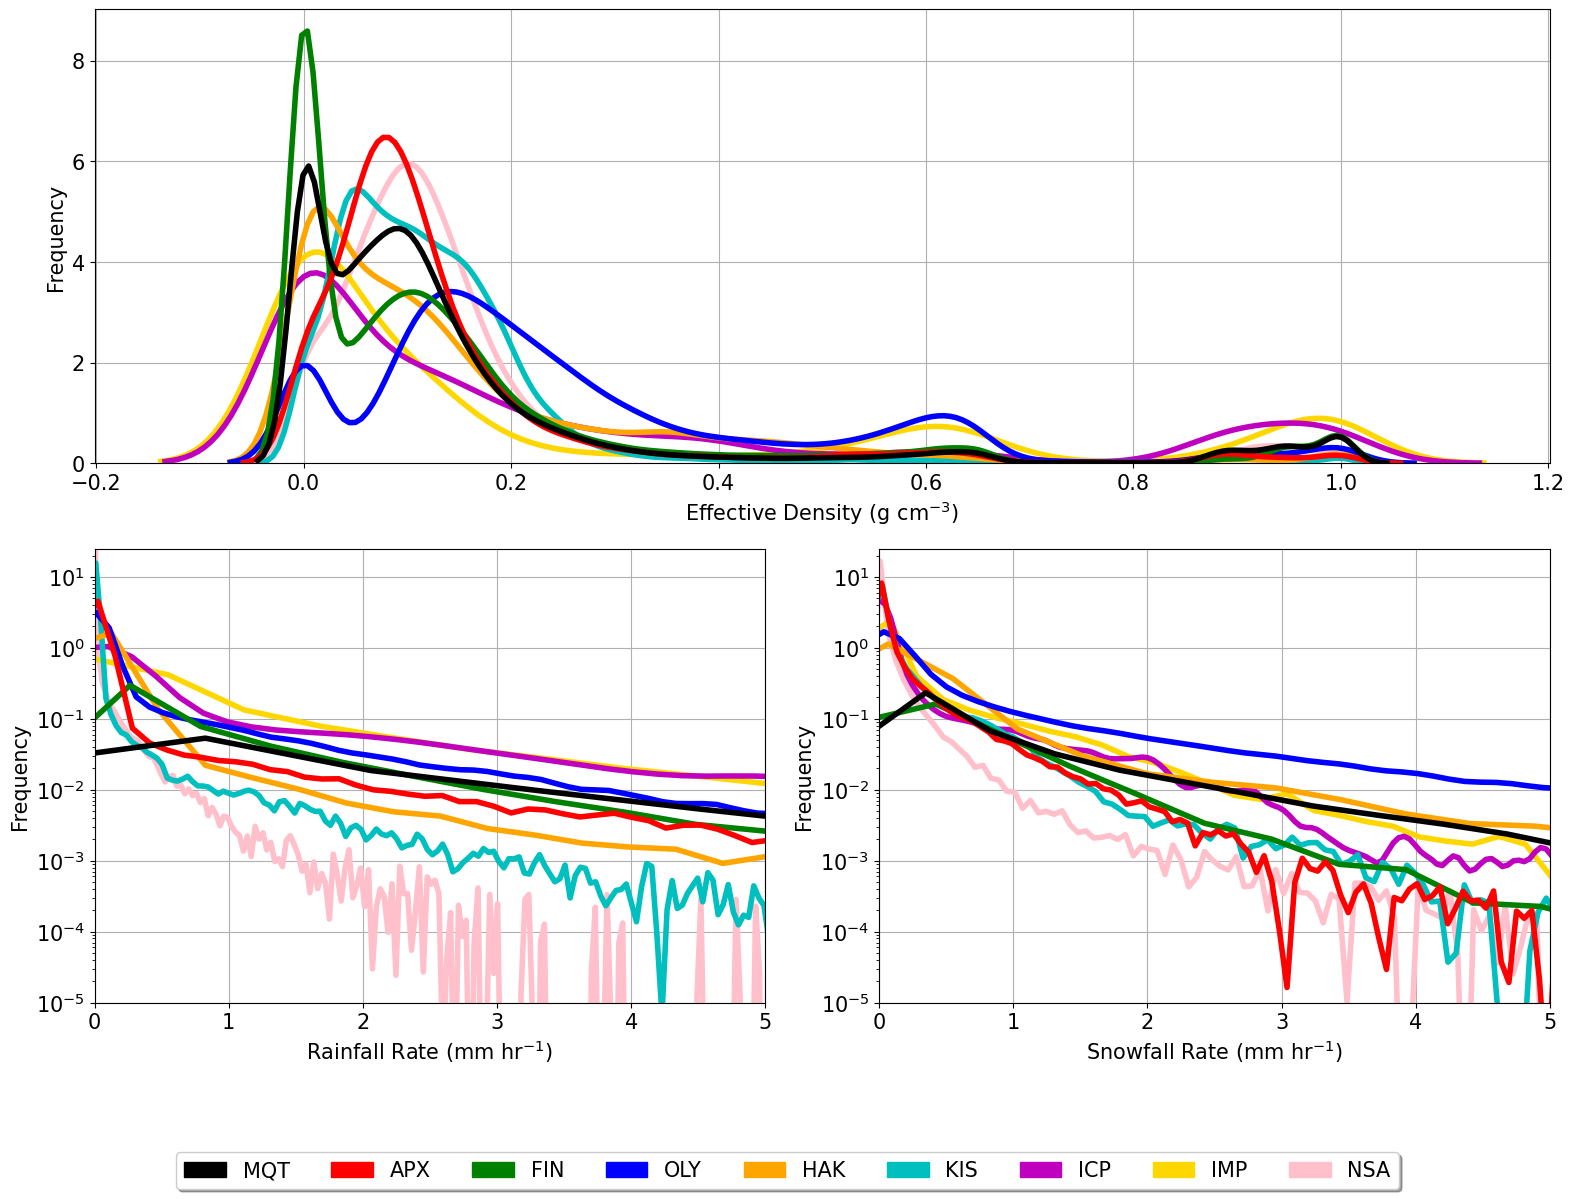

In [15]:
def make_minute_plots():
    def replace_vars(data):
        concatenated_subarray = data[6] + data[7]
        data[6] = concatenated_subarray
        del data[7]
        return data

    def flatten_2d_list(lst):
        flat_list = []
        for sublist in lst:
            for item in sublist:
                flat_list.append(item)
        return flat_list

    def create_dataframe(arr):
        transformed_data = []
        names = ['MQT', 'APX', 'FIN', 'OLY', 'HAK', 'KIS', 'ICP', 'IMP', 'NSA']

        for i,row in enumerate(arr):
            site = names[i]
            values = flatten_2d_list(row)
            for value in values:
                transformed_data.append([site, value])

        return pd.DataFrame(transformed_data, columns=['Site', 'Value'])

    def create_1d_hist_min_vars():
        names = ['MQT', 'APX', 'FIN', 'HUR', 'HAUK', 'KIS', 'KO1', 'KO2', 'IMP', 'NSA']
        base_folder = '/Users/fraserking/Development/pip_processing/data/converted'
        cmap = plt.get_cmap('inferno')
        cmap.set_bad(color='black')

        # Initialize arrays to store N0 and lambda values
        site_ed_array = []
        site_rr_array = []
        site_nrr_array = []
        site_vvd_array = []

        for site_name in names:
            print(f"Working on {site_name}")
            
            ed_list = []
            rr_list = []
            nrr_list = []
            vvd_list = []

            subdirs = [d for d in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, d))]
            matching_subdirs = [d for d in subdirs if site_name in d]
            
            for subdir in matching_subdirs:
                full_path = os.path.join(base_folder, subdir)
                print(f"Processing subdirectory: {full_path}")

                vars = ['netCDF/adjusted_edensity_lwe_rate', 'netCDF/velocity_distributions']
                
                for i, var in enumerate(vars):
                    netcdf_path = os.path.join(full_path, var)
                    if os.path.exists(netcdf_path):
                        all_files = os.listdir(netcdf_path)
                        nc_files = [f for f in all_files if f.endswith('.nc')]
                        
                        for nc_file in nc_files:
                            nc_file_path = os.path.join(netcdf_path, nc_file)
                            ds_pip = xr.open_dataset(nc_file_path)   

                            if i == 0:
                                ed = ds_pip['ed_adj'].values
                                if np.nanmax(ed) > 1 or np.nanmin(ed) < 0:
                                    print("\n\nPROBLEM!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
                                    print(np.nanmax(ed), np.nanmin(ed))
                                    print(f"Processing file: {nc_file_path}")
                                rr = ds_pip['rr_adj'].values
                                nrr = ds_pip['nrr_adj'].values
                                ed_list.append(ed.flatten())
                                rr_list.append(rr.flatten())
                                nrr_list.append(nrr.flatten())
                            else:
                                vvd = ds_pip['vvd'].T.values
                                vvd_list.append(vvd.flatten())


            site_ed_array.append(ed_list)
            site_rr_array.append(rr_list)
            site_nrr_array.append(nrr_list)
            site_vvd_array.append(vvd_list)

        return site_ed_array, site_rr_array, site_nrr_array, site_vvd_array

    site_ed_array, site_rr_array, site_nrr_array, site_vvd_array = create_1d_hist_min_vars()

    site_ed_array = replace_vars(site_ed_array)
    site_rr_array = replace_vars(site_rr_array)
    site_nrr_array = replace_vars(site_nrr_array)
    site_vvd_array = replace_vars(site_vvd_array)

    df_ed = create_dataframe(site_ed_array)
    df_rr = create_dataframe(site_rr_array)
    df_nrr = create_dataframe(site_nrr_array)


    def plot_min_vars(ax, variable, title, use_log, colors):
        names = ['MQT', 'APX', 'FIN', 'OLY', 'HAK', 'KIS', 'ICP', 'IMP', 'NSA']
        ax.grid()
        sns.kdeplot(data=variable, x='Value', hue="Site", common_norm=False, ax=ax, palette=colors, lw=4)
        ax.get_legend().set_visible(False)
        ax.set_xlabel(title)
        ax.set_ylabel("Frequency")
        if use_log:
            ax.set_yscale('log')
            ax.set_ylim(0.00001, 25)
            ax.set_xlim(0, 5)

    # Initialize colors and figure
    colors = ['black', 'r', 'g', 'b', 'orange', 'c', 'm', 'gold', 'pink']

    fig = plt.figure(figsize=(16, 11))
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[0.5, 0.5])

    # Create individual subplots
    ax0 = plt.subplot(gs[0, :])
    ax1 = plt.subplot(gs[1, 0])
    ax2 = plt.subplot(gs[1, 1])

    # Plot the individual subplots
    plot_min_vars(ax0, df_ed, 'Effective Density (g cm$^{-3}$)', False, colors)
    plot_min_vars(ax1, df_rr, 'Rainfall Rate (mm hr$^{-1}$)', True, colors)
    plot_min_vars(ax2, df_nrr, 'Snowfall Rate (mm hr$^{-1}$)', True, colors)

    # Create legend handles
    names = ['MQT', 'APX', 'FIN', 'OLY', 'HAK', 'KIS', 'ICP', 'IMP', 'NSA']
    legend_handles = [mpatches.Patch(color=color, label=name) for color, name in zip(colors, names)]

    # Add a single custom legend at the bottom
    fig.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=9)

    plt.tight_layout()
    plt.show()


############ RUN
# make_minute_plots()


In [9]:
################# MRR DATA

# START -> 2000
# Thursday, 21 November 2019 08:19:00 (1574324340.0) to Friday, 22 November 2019 09:18:00 (1574414280.0)
def plot_data_for_day(year1, month1, day1, year2, month2, day2):

    SITE = 'MQT'

    pip_path = '../data/PIP/2019_' + SITE + '/netCDF/'
    mrr_path = '../data/MRR/'
    met_path = '../data/MET/'
    era_path = '../data/ERA5/'

    NANO_FACTOR = 1000000000

    date = year1 + month1 + day1
    date2 = year2 + month2 + day2
    ds_mrr = xr.open_dataset(mrr_path + 'MRR_NWS_' + SITE + '_' + date + '_snow.nc')
    ds_mrr2 = xr.open_dataset(mrr_path + 'MRR_NWS_' + SITE + '_' + date2 + '_snow.nc')
    
    vline1 = 415
    vline2 = 575

    ax_shared = None

    ze = ds_mrr['Ze'].values
    dv = ds_mrr['W'].values
    sw = ds_mrr['spectralWidth'].values
    ze2 = ds_mrr2['Ze'].values
    dv2 = ds_mrr2['W'].values
    sw2 = ds_mrr2['spectralWidth'].values
    
    ze = np.concatenate([ze, ze2], axis=0)[500:2000,:]
    dv = np.concatenate([dv, dv2], axis=0)[500:2000,:]
    sw = np.concatenate([sw, sw2], axis=0)[500:2000,:]

    fig = plt.figure(figsize=(14,25))
    # fig.suptitle(SITE + ' ' + date)
    gs = gridspec.GridSpec(8, 2, width_ratios=[1, 0.025]) 
    ax = plt.subplot(gs[0, 0], sharex=ax_shared)
    ax.patch.set_facecolor('#000871')
    plt.grid(alpha=0.5)
    h = ax.imshow(ze.T, cmap='gist_ncar', vmin=-5, vmax=35, aspect='auto')
    ax.axvline(vline1, linewidth=2, linestyle='--', color='black')
    ax.axvline(vline2, linewidth=2, linestyle='--', color='black')
    cbar_ax = plt.subplot(gs[0, 1])
    cbar = fig.colorbar(h, cax=cbar_ax)
    cbar.set_label("Reflectivity (dBZ)")
    custom_y_labs = [0, 1, 2, 3]
    custom_y_indices = [0, 10, 20, 30]
    ax.set_yticks(custom_y_indices)
    ax.set_yticklabels(custom_y_labs)
    ax.set_ylabel("Height AGL (km)")
    ax.invert_yaxis()
    
    ax = plt.subplot(gs[1, 0], sharex=ax_shared)
    plt.grid(alpha=0.5)
    h = ax.imshow(dv.T, cmap='coolwarm', vmin=-3, vmax=3, aspect='auto')
    ax.axvline(vline1, linewidth=2, linestyle='--', color='black')
    ax.axvline(vline2, linewidth=2, linestyle='--', color='black')
    cbar_ax = plt.subplot(gs[1, 1])
    cbar = fig.colorbar(h, cax=cbar_ax)
    cbar.set_label("Doppler Velocity (m s$^{-1}$)")
    ax.set_ylabel("Height AGL (km)")
    custom_y_labs = [0, 1, 2, 3]
    custom_y_indices = [0, 10, 20, 30]
    ax.set_yticks(custom_y_indices)
    ax.set_yticklabels(custom_y_labs)
    ax.invert_yaxis()
    
    # ax = plt.subplot(gs[2, 0])
    # h = ax.imshow(sw.T, cmap='viridis', vmin=0, vmax=1, aspect='auto')
    # cbar_ax = plt.subplot(gs[2, 1])
    # cbar = fig.colorbar(h, cax=cbar_ax)
    # cbar.set_label("Spectral Width (m s-1)")
    # ax.set_ylabel("Bin")
    # ax.invert_yaxis()
    
    ax = plt.subplot(gs[2, 0], sharex=ax_shared)
    plt.grid(alpha=0.5)
    ax.patch.set_facecolor('#0b0780')
    ds_pip = xr.open_dataset(pip_path + '/particle_size_distributions/006' + date + '2350_01_dsd.nc')   
    ds_pip2 = xr.open_dataset(pip_path + '/particle_size_distributions/006' + date2 + '2350_01_dsd.nc')   
    cbar_ax = plt.subplot(gs[2, 1])
    val = ds_pip['psd'].values
    val2 = ds_pip2['psd'].values
    h = ax.imshow(np.concatenate([val, val2])[500:2000,:].T, cmap='plasma', norm=LogNorm(vmin=0.1, vmax=10000), aspect='auto')
    ax.axvline(vline1, linewidth=2, linestyle='--', color='black')
    ax.axvline(vline2, linewidth=2, linestyle='--', color='black')
    cbar = fig.colorbar(h, cax=cbar_ax)
    cbar.set_label('PSD (m$^{−3}$ mm$^{−1}$)')
    bin_centers = ds_pip.bin_centers.values
    ticks_idx = np.linspace(0, len(bin_centers) - 50, 4, dtype=int)
    ax.set_yticks(ticks_idx)
    ax.set_yticklabels(bin_centers[ticks_idx])
    ax.set_ylim((0, 81))
    ax.invert_yaxis()
    ax.set_ylabel('Mean D (mm)')
    ax.invert_yaxis()
    
    ax = plt.subplot(gs[3, 0], sharex=ax_shared)
    plt.grid(alpha=0.5)
    ax.patch.set_facecolor('#0b0780')
    ds_pip = xr.open_dataset(pip_path + '/velocity_distributions/006' + date + '2350_01_vvd_A.nc')
    ds_pip2 = xr.open_dataset(pip_path + '/velocity_distributions/006' + date2 + '2350_01_vvd_A.nc')
    cbar_ax = plt.subplot(gs[3, 1])   
    val = ds_pip['vvd'].values
    val2 = ds_pip2['vvd'].values
    h = ax.imshow(np.concatenate([val, val2])[500:2000,:].T, cmap='plasma', vmin=0, vmax=3, aspect='auto')
    ax.axvline(vline1, linewidth=2, linestyle='--', color='black')
    ax.axvline(vline2, linewidth=2, linestyle='--', color='black')
    cbar = fig.colorbar(h, cax=cbar_ax)
    cbar.set_label('VVD (m s$^{-1}$)')
    bin_centers = ds_pip.bin_centers.values
    ticks_idx = np.linspace(0, len(bin_centers) - 50, 4, dtype=int)
    ax.set_yticks(ticks_idx)
    ax.set_yticklabels(bin_centers[ticks_idx])
    ax.set_ylim((0, 81))
    ax.invert_yaxis()
    ax.set_ylabel('Mean D (mm)')
    ax.invert_yaxis()
    
    ax = plt.subplot(gs[4, 0], sharex=ax_shared)
    plt.grid(alpha=0.5)
    ax.patch.set_facecolor('white')
    ds_pip = xr.open_dataset(pip_path + '/edensity_distributions/006' + date + '2350_01_rho_Plots_D_minute.nc')  
    ds_pip2 = xr.open_dataset(pip_path + '/edensity_distributions/006' + date2 + '2350_01_rho_Plots_D_minute.nc') 
    cbar_ax = plt.subplot(gs[4, 1])
    val = ds_pip['rho'].values
    val2 = ds_pip2['rho'].values

    final_ed = np.concatenate([val, val2])[500:2000,:].T
    final_ed[final_ed <= 0] = np.nan

    h = ax.imshow(final_ed, cmap='seismic', vmin=0, vmax=1, aspect='auto')
    ax.axvline(vline1, linewidth=2, linestyle='--', color='black')
    ax.axvline(vline2, linewidth=2, linestyle='--', color='black')
    cbar = fig.colorbar(h, cax=cbar_ax)
    cbar.set_label('Rho (g cm$^{-3}$)')
    bin_centers = ds_pip.bin_centers.values
    ticks_idx = np.linspace(0, len(bin_centers) - 50, 4, dtype=int)
    ax.set_yticks(ticks_idx)
    ax.set_yticklabels(bin_centers[ticks_idx])
    ax.set_ylim((0, 81))
    ax.invert_yaxis()
    ax.set_ylabel('Mean D (mm)')
    ax.invert_yaxis()
    
    ax = plt.subplot(gs[5, 0], sharex=ax_shared)
    plt.grid(alpha=0.5)
    ds_lwe = xr.open_dataset(pip_path + '/adjusted_edensity_lwe_rate/006' + date + '2350_01_P_Minute.nc')  
    ds_lwe2 = xr.open_dataset(pip_path + '/adjusted_edensity_lwe_rate/006' + date2 + '2350_01_P_Minute.nc')   
    val = ds_lwe['nrr_adj'].values[500:2000]
    val2 = ds_lwe2['nrr_adj'].values[0:1000]
    rrval = ds_lwe['rr_adj'].values[500:2000]
    rrval2 = ds_lwe2['rr_adj'].values[0:1000]
    ax.set_xlim((0, 1500))
    ax.plot(np.arange(len(np.concatenate([val, val2]))), np.concatenate([val, val2]), color='blue', linewidth=2, label='Snow')
    ax.plot(np.arange(len(np.concatenate([rrval, rrval2]))), np.concatenate([rrval, rrval2]), color='red', linewidth=2, label='Rain')
    ax.axvline(vline1, linewidth=2, linestyle='--', color='black')
    ax.axvline(vline2, linewidth=2, linestyle='--', color='black')
    ax.legend(loc='upper left')
    ax.set_ylabel('Rate (mm hr$^{-1}$)')

    ## ERA5
    ds_era5 = xr.open_dataset(era_path + '/temperature.nc')
    data_slice = ds_era5.t[33:58, :, 2, 2]
    data_array = data_slice.values - 273.15 
    time_units = np.linspace(0, 24, 25) 
    levels = np.linspace(0, 19, 20)
    Time, Level = np.meshgrid(time_units, levels)

    ax = plt.subplot(gs[6, 0], sharex=ax_shared)
    plt.grid(alpha=0.5)
    contour = ax.contourf(Time, Level, data_array.T, cmap='inferno', levels=20) 
    zero_degree_contour = ax.contour(Time, Level, data_array.T, levels=[0], colors='black', linestyles='dashed')
    ax.axvline(6.65, linewidth=2, linestyle='--', color='black')
    ax.axvline(9.2, linewidth=2, linestyle='--', color='black')
    plt.gca().invert_yaxis()
    custom_pressure_levels = ['300', '550', '800', '1000']
    custom_pressure_indices = [0, 5, 11, 19]
    ax.set_yticks(custom_pressure_indices)
    ax.set_yticklabels(custom_pressure_levels)
    ax.set_xticks([0, 3.2, 6.4, 9.6, 12.8, 16, 19.2, 22.4])
    cbar_ax = plt.subplot(gs[6, 1])
    cbar = fig.colorbar(contour, cax=cbar_ax)
    cbar.set_label('Temperature (°C)')
    ax.set_ylabel('Pressure (hPa)')

    ax = plt.subplot(gs[7, 0], sharex=ax_shared)
    plt.grid(alpha=0.5)
    ds_met = xr.open_dataset(met_path + '2013-2020_' + SITE + '.nc')
    times = np.asarray((ds_met['UTC Time'].values / 1000000000), dtype=int)
    utc_time = pd.to_datetime(times, unit='s', origin='unix')
    ds_met = ds_met.assign_coords(time = utc_time)
    ds_met2 = ds_met.sel(time=(ds_met['time.year']==int(year2)) & (ds_met['time.month']==int(month2)) & (ds_met['time.day']==int(day2)))
    ds_met = ds_met.sel(time=(ds_met['time.year']==int(year1)) & (ds_met['time.month']==int(month1)) & (ds_met['time.day']==int(day1)))
    
    t = ds_met['Temp Out'].values  
    p = ds_met['Wind Speed'].values 
    t2 = ds_met2['Temp Out'].values  
    p2 = ds_met2['Wind Speed'].values
    d = ds_met['Dew Point'].values
    d2 = ds_met2['Dew Point'].values

    ax.plot(np.arange(len(np.append(t, t2)[100:399])), np.append(t, t2)[100:399], color='black', linewidth=2, label='T')
    ax.plot(np.arange(len(np.append(d, d2)[100:399])), np.append(d, d2)[100:399], color='gray', linewidth=2, label='DP')
    ax.legend(loc='upper left')
    ax.axhline(y=0, linestyle='--', color='black')
    ax.set_ylabel('Temperature (°C)')
    ax.set_xlim((0, 299))
    
    ax2 = ax.twinx()
    ax2.set_xlim((0, 299))
    ax2.plot(np.arange(len(np.append(p, p2)[100:399])), np.append(p, p2)[100:399], linewidth=2, color='red')
    ax2.axvline(83, linewidth=2, linestyle='--', color='black')
    ax2.axvline(115, linewidth=2, linestyle='--', color='black')
    ax2.set_ylabel('WS (m s$^{-1}$)')
    ax2.spines['right'].set_color('red')
    ax2.yaxis.label.set_color('red')
    ax2.tick_params(axis='y', colors='red') 
    ax_shared = ax
    ax.set_xticks(np.linspace(0, 279, 8)) 
    time_labels = pd.date_range(start='21 November 2019 08:19:00', end='22 November 2019 09:18:00', periods=8)
    ax.set_xticklabels(time_labels.strftime('%Y/%m/%d %H:%M:%S'), rotation=45, ha='right')

    for ax in fig.get_axes():
        if ax != ax_shared:
            plt.setp(ax.get_xticklabels(), visible=False)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
# plot_data_for_day('2019', '11', '21', '2019', '11', '22')


In [10]:
################# MRR DATA

# 500 -> 2000
# Thursday, 21 November 2019 08:19:00 (1574324340.0) to Friday, 22 November 2019 09:18:00 (1574414280.0)
def plot_data_for_day(year1, month1, day1, year2, month2, day2):

    SITE = 'MQT'

    pip_path = '../data/PIP/2017_' + SITE + '/netCDF/'
    mrr_path = '../data/MRR/'
    met_path = '../data/MET/'
    era_path = '../data/ERA5/'

    NANO_FACTOR = 1000000000

    date = year1 + month1 + day1
    date2 = year2 + month2 + day2
    ds_mrr = xr.open_dataset(mrr_path + 'MRR_NWS_' + SITE + '_' + date + '_snow.nc')
    ds_mrr2 = xr.open_dataset(mrr_path + 'MRR_NWS_' + SITE + '_' + date2 + '_snow.nc')
    
    vline1 = 208
    vline2 = 660

    START = 780
    END = 1680
    END2 = 240

    ax_shared = None

    ze = ds_mrr['Ze'].values
    dv = ds_mrr['W'].values
    sw = ds_mrr['spectralWidth'].values
    ze2 = ds_mrr2['Ze'].values
    dv2 = ds_mrr2['W'].values
    sw2 = ds_mrr2['spectralWidth'].values
    
    ze = np.concatenate([ze, ze2], axis=0)[START:END,:]
    dv = np.concatenate([dv, dv2], axis=0)[START:END,:]
    sw = np.concatenate([sw, sw2], axis=0)[START:END,:]

    fig = plt.figure(figsize=(14,25))
    # fig.suptitle(SITE + ' ' + date)
    gs = gridspec.GridSpec(8, 2, width_ratios=[1, 0.025]) 
    ax = plt.subplot(gs[0, 0], sharex=ax_shared)
    ax.patch.set_facecolor('#000871')
    plt.grid(alpha=0.5)
    h = ax.imshow(ze.T, cmap='gist_ncar', vmin=-5, vmax=35, aspect='auto')
    ax.axvline(vline1, linewidth=2, linestyle='--', color='black')
    ax.axvline(vline2, linewidth=2, linestyle='--', color='black')
    cbar_ax = plt.subplot(gs[0, 1])
    cbar = fig.colorbar(h, cax=cbar_ax)
    cbar.set_label("Reflectivity (dBZ)")
    custom_y_labs = [0, 1, 2, 3]
    custom_y_indices = [0, 10, 20, 30]
    ax.set_yticks(custom_y_indices)
    ax.set_yticklabels(custom_y_labs)
    ax.set_ylabel("Height AGL (km)")
    ax.invert_yaxis()
    
    ax = plt.subplot(gs[1, 0], sharex=ax_shared)
    plt.grid(alpha=0.5)
    h = ax.imshow(dv.T, cmap='coolwarm', vmin=-3, vmax=3, aspect='auto')
    ax.axvline(vline1, linewidth=2, linestyle='--', color='black')
    ax.axvline(vline2, linewidth=2, linestyle='--', color='black')
    cbar_ax = plt.subplot(gs[1, 1])
    cbar = fig.colorbar(h, cax=cbar_ax)
    cbar.set_label("Doppler Velocity (m s$^{-1}$)")
    ax.set_ylabel("Height AGL (km)")
    custom_y_labs = [0, 1, 2, 3]
    custom_y_indices = [0, 10, 20, 30]
    ax.set_yticks(custom_y_indices)
    ax.set_yticklabels(custom_y_labs)
    ax.invert_yaxis()
    
    # ax = plt.subplot(gs[2, 0])
    # h = ax.imshow(sw.T, cmap='viridis', vmin=0, vmax=1, aspect='auto')
    # cbar_ax = plt.subplot(gs[2, 1])
    # cbar = fig.colorbar(h, cax=cbar_ax)
    # cbar.set_label("Spectral Width (m s-1)")
    # ax.set_ylabel("Bin")
    # ax.invert_yaxis()
    
    ax = plt.subplot(gs[2, 0], sharex=ax_shared)
    plt.grid(alpha=0.5)
    ax.patch.set_facecolor('#0b0780')
    ds_pip = xr.open_dataset(pip_path + '/particle_size_distributions/006' + date + '2350_01_dsd.nc')   
    ds_pip2 = xr.open_dataset(pip_path + '/particle_size_distributions/006' + date2 + '2350_01_dsd.nc')   
    cbar_ax = plt.subplot(gs[2, 1])
    val = ds_pip['psd'].values
    val2 = ds_pip2['psd'].values
    h = ax.imshow(np.concatenate([val, val2])[START:END,:].T, cmap='plasma', norm=LogNorm(vmin=0.1, vmax=10000), aspect='auto')
    ax.axvline(vline1, linewidth=2, linestyle='--', color='black')
    ax.axvline(vline2, linewidth=2, linestyle='--', color='black')
    cbar = fig.colorbar(h, cax=cbar_ax)
    cbar.set_label('PSD (m$^{−3}$ mm$^{−1}$)')
    bin_centers = ds_pip.bin_centers.values
    ticks_idx = np.linspace(0, len(bin_centers) - 50, 4, dtype=int)
    ax.set_yticks(ticks_idx)
    ax.set_yticklabels(bin_centers[ticks_idx])
    ax.set_ylim((0, 81))
    ax.invert_yaxis()
    ax.set_ylabel('Mean D (mm)')
    ax.invert_yaxis()
    
    ax = plt.subplot(gs[3, 0], sharex=ax_shared)
    plt.grid(alpha=0.5)
    ax.patch.set_facecolor('#0b0780')
    ds_pip = xr.open_dataset(pip_path + '/velocity_distributions/006' + date + '2350_01_vvd_A.nc')
    ds_pip2 = xr.open_dataset(pip_path + '/velocity_distributions/006' + date2 + '2350_01_vvd_A.nc')
    cbar_ax = plt.subplot(gs[3, 1])   
    val = ds_pip['vvd'].values
    val2 = ds_pip2['vvd'].values
    h = ax.imshow(np.concatenate([val, val2])[START:END,:].T, cmap='plasma', vmin=0, vmax=3, aspect='auto')
    ax.axvline(vline1, linewidth=2, linestyle='--', color='black')
    ax.axvline(vline2, linewidth=2, linestyle='--', color='black')
    cbar = fig.colorbar(h, cax=cbar_ax)
    cbar.set_label('VVD (m s$^{-1}$)')
    bin_centers = ds_pip.bin_centers.values
    ticks_idx = np.linspace(0, len(bin_centers) - 50, 4, dtype=int)
    ax.set_yticks(ticks_idx)
    ax.set_yticklabels(bin_centers[ticks_idx])
    ax.set_ylim((0, 81))
    ax.invert_yaxis()
    ax.set_ylabel('Mean D (mm)')
    ax.invert_yaxis()
    
    ax = plt.subplot(gs[4, 0], sharex=ax_shared)
    plt.grid(alpha=0.5)
    ax.patch.set_facecolor('white')
    ds_pip = xr.open_dataset(pip_path + '/edensity_distributions/006' + date + '2350_01_rho_Plots_D_minute.nc')  
    ds_pip2 = xr.open_dataset(pip_path + '/edensity_distributions/006' + date2 + '2350_01_rho_Plots_D_minute.nc') 
    cbar_ax = plt.subplot(gs[4, 1])
    val = ds_pip['rho'].values
    val2 = ds_pip2['rho'].values

    final_ed = np.concatenate([val, val2])[START:END,:].T
    final_ed[final_ed <= 0] = np.nan

    h = ax.imshow(final_ed, cmap='seismic', vmin=0, vmax=1, aspect='auto')
    ax.axvline(vline1, linewidth=2, linestyle='--', color='black')
    ax.axvline(vline2, linewidth=2, linestyle='--', color='black')
    cbar = fig.colorbar(h, cax=cbar_ax)
    cbar.set_label('Rho (g cm$^{-3}$)')
    bin_centers = ds_pip.bin_centers.values
    ticks_idx = np.linspace(0, len(bin_centers) - 50, 4, dtype=int)
    ax.set_yticks(ticks_idx)
    ax.set_yticklabels(bin_centers[ticks_idx])
    ax.set_ylim((0, 81))
    ax.invert_yaxis()
    ax.set_ylabel('Mean D (mm)')
    ax.invert_yaxis()
    
    ax = plt.subplot(gs[5, 0], sharex=ax_shared)
    plt.grid(alpha=0.5)
    ds_lwe = xr.open_dataset(pip_path + '/adjusted_edensity_lwe_rate/006' + date + '2350_01_P_Minute.nc')  
    ds_lwe2 = xr.open_dataset(pip_path + '/adjusted_edensity_lwe_rate/006' + date2 + '2350_01_P_Minute.nc')   
    val = ds_lwe['nrr_adj'].values[START:]
    val2 = ds_lwe2['nrr_adj'].values[:END2]
    rrval = ds_lwe['rr_adj'].values[START:]
    rrval2 = ds_lwe2['rr_adj'].values[:END2]
    ax.set_xlim((0, 900))
    ax.plot(np.arange(len(np.concatenate([val, val2]))), np.concatenate([val, val2]), color='blue', linewidth=2, label='Snow')
    ax.plot(np.arange(len(np.concatenate([rrval, rrval2]))), np.concatenate([rrval, rrval2]), color='red', linewidth=2, label='Rain')
    ax.axvline(vline1, linewidth=2, linestyle='--', color='black')
    ax.axvline(vline2, linewidth=2, linestyle='--', color='black')
    ax.legend(loc='upper left')
    ax.set_ylabel('Rate (mm hr$^{-1}$)')

    ## ERA5
    ds_era5 = xr.open_dataset(era_path + '/temperature2.nc')
    data_slice = ds_era5.t[36:51, :, 2, 2]
    data_array = data_slice.values - 273.15 
    time_units = np.linspace(0, 14, 15) 
    levels = np.linspace(0, 19, 20)
    Time, Level = np.meshgrid(time_units, levels)

    ax = plt.subplot(gs[6, 0], sharex=ax_shared)
    plt.grid(alpha=0.5)
    contour = ax.contourf(Time, Level, data_array.T, cmap='inferno', levels=20)
    zero_degree_contour = ax.contour(Time, Level, data_array.T, levels=[0], colors='black', linestyles='dashed')
    ax.axvline(3.25, linewidth=2, linestyle='--', color='black')
    ax.axvline(10.25, linewidth=2, linestyle='--', color='black')
    plt.gca().invert_yaxis()
    custom_pressure_levels = ['300', '550', '800', '1000']
    custom_pressure_indices = [0, 5, 11, 19]
    ax.set_yticks(custom_pressure_indices)
    ax.set_yticklabels(custom_pressure_levels)
    ax.set_xticks(np.arange(0, 15, 1.555))
    cbar_ax = plt.subplot(gs[6, 1])
    cbar = fig.colorbar(contour, cax=cbar_ax)
    cbar.set_label('Temperature (°C)')
    ax.set_ylabel('Pressure (hPa)')

    ax = plt.subplot(gs[7, 0], sharex=ax_shared)
    plt.grid(alpha=0.5)
    ds_met = xr.open_dataset(met_path + '2013-2020_' + SITE + '.nc')
    times = np.asarray((ds_met['UTC Time'].values / 1000000000), dtype=int)
    utc_time = pd.to_datetime(times, unit='s', origin='unix')
    ds_met = ds_met.assign_coords(time = utc_time)
    ds_met2 = ds_met.sel(time=(ds_met['time.year']==int(year2)) & (ds_met['time.month']==int(month2)) & (ds_met['time.day']==int(day2)))
    ds_met = ds_met.sel(time=(ds_met['time.year']==int(year1)) & (ds_met['time.month']==int(month1)) & (ds_met['time.day']==int(day1)))
    
    t = ds_met['Temp Out'].values  
    p = ds_met['Wind Speed'].values 
    t2 = ds_met2['Temp Out'].values  
    p2 = ds_met2['Wind Speed'].values
    d = ds_met['Dew Point'].values
    d2 = ds_met2['Dew Point'].values

    print(len(t))

    ax.plot(np.arange(len(np.append(t, t2)[156:336])), np.append(t, t2)[156:336], color='black', linewidth=2, label='T')
    ax.plot(np.arange(len(np.append(d, d2)[156:336])), np.append(d, d2)[156:336], color='gray', linewidth=2, label='DP')
    ax.legend(loc='upper right')
    ax.axhline(y=0, linestyle='--', color='black')
    ax.set_ylabel('Temperature (°C)')
    ax.set_xlim((0, 180))
    
    ax2 = ax.twinx()
    ax2.set_xlim((0, 180))
    ax2.plot(np.arange(len(np.append(p, p2)[156:336])), np.append(p, p2)[156:336], linewidth=2, color='red')
    ax2.axvline(42, linewidth=2, linestyle='--', color='black')
    ax2.axvline(132, linewidth=2, linestyle='--', color='black')
    ax2.set_ylabel('WS (m s$^{-1}$)')
    ax2.spines['right'].set_color('red')
    ax2.yaxis.label.set_color('red')
    ax2.tick_params(axis='y', colors='red') 
    ax_shared = ax
    ax.set_xticks(np.linspace(0, 180, 10)) 
    time_labels = pd.date_range(start='17 November 2017 13:00:00', end='18 November 2017 04:00:00', periods=10)
    ax.set_xticklabels(time_labels.strftime('%Y/%m/%d %H:%M:%S'), rotation=45, ha='right')

    for ax in fig.get_axes():
        if ax != ax_shared:
            plt.setp(ax.get_xticklabels(), visible=False)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
# plot_data_for_day('2017', '11', '17', '2017', '11', '18')


In [11]:

# # 500 -> 2000
# # Thursday, 21 November 2019 08:19:00 (1574324340.0) to Friday, 22 November 2019 09:18:00 (1574414280.0)
# def plot_data_for_day(year1, month1, day1):

#     SITE = 'MQT'

#     pip_path = '../data/PIP/2015_' + SITE + '/netCDF/'
#     mrr_path = '../data/MRR/'
#     met_path = '../data/MET/'
#     era_path = '../data/ERA5/'

#     NANO_FACTOR = 1000000000

#     date = year1 + month1 + day1
#     ds_mrr = xr.open_dataset(mrr_path + 'MRR_NWS_' + SITE + '_' + date + '_snow.nc')
    
#     vline1 = 365
#     vline2 = 485

#     ax_shared = None

#     ze = ds_mrr['Ze'].values
#     dv = ds_mrr['W'].values
#     sw = ds_mrr['spectralWidth'].values

#     fig = plt.figure(figsize=(14,25))
#     # fig.suptitle(SITE + ' ' + date)
#     gs = gridspec.GridSpec(8, 2, width_ratios=[1, 0.025]) 
#     ax = plt.subplot(gs[0, 0], sharex=ax_shared)
#     ax.patch.set_facecolor('#000871')
#     plt.grid(alpha=0.5)
#     h = ax.imshow(ze.T, cmap='gist_ncar', vmin=-5, vmax=35, aspect='auto')
#     ax.axvline(vline1, linewidth=2, linestyle='--', color='black')
#     ax.axvline(vline2, linewidth=2, linestyle='--', color='black')
#     cbar_ax = plt.subplot(gs[0, 1])
#     cbar = fig.colorbar(h, cax=cbar_ax)
#     cbar.set_label("Reflectivity (dBZ)")
#     custom_y_labs = [0, 1, 2, 3]
#     custom_y_indices = [0, 10, 20, 30]
#     ax.set_yticks(custom_y_indices)
#     ax.set_yticklabels(custom_y_labs)
#     ax.set_ylabel("Height AGL (km)")
#     ax.invert_yaxis()
    
#     ax = plt.subplot(gs[1, 0], sharex=ax_shared)
#     plt.grid(alpha=0.5)
#     h = ax.imshow(dv.T, cmap='coolwarm', vmin=-3, vmax=3, aspect='auto')
#     ax.axvline(vline1, linewidth=2, linestyle='--', color='black')
#     ax.axvline(vline2, linewidth=2, linestyle='--', color='black')
#     cbar_ax = plt.subplot(gs[1, 1])
#     cbar = fig.colorbar(h, cax=cbar_ax)
#     cbar.set_label("Doppler Velocity (m s$^{-1}$)")
#     ax.set_ylabel("Height AGL (km)")
#     custom_y_labs = [0, 1, 2, 3]
#     custom_y_indices = [0, 10, 20, 30]
#     ax.set_yticks(custom_y_indices)
#     ax.set_yticklabels(custom_y_labs)
#     ax.invert_yaxis()
    
#     # ax = plt.subplot(gs[2, 0])
#     # h = ax.imshow(sw.T, cmap='viridis', vmin=0, vmax=1, aspect='auto')
#     # cbar_ax = plt.subplot(gs[2, 1])
#     # cbar = fig.colorbar(h, cax=cbar_ax)
#     # cbar.set_label("Spectral Width (m s-1)")
#     # ax.set_ylabel("Bin")
#     # ax.invert_yaxis()
    
#     ax = plt.subplot(gs[2, 0], sharex=ax_shared)
#     plt.grid(alpha=0.5)
#     ax.patch.set_facecolor('#0b0780')
#     ds_pip = xr.open_dataset(pip_path + '/particle_size_distributions/006' + date + '2350_01_dsd.nc')   
#     cbar_ax = plt.subplot(gs[2, 1])
#     val = ds_pip['psd'].values
#     h = ax.imshow(val.T, cmap='plasma', norm=LogNorm(vmin=0.1, vmax=10000), aspect='auto')
#     ax.axvline(vline1, linewidth=2, linestyle='--', color='black')
#     ax.axvline(vline2, linewidth=2, linestyle='--', color='black')
#     cbar = fig.colorbar(h, cax=cbar_ax)
#     cbar.set_label('PSD (m$^{−3}$ mm$^{−1}$)')
#     bin_centers = ds_pip.bin_centers.values
#     ticks_idx = np.linspace(0, len(bin_centers) - 50, 4, dtype=int)
#     ax.set_yticks(ticks_idx)
#     ax.set_yticklabels(bin_centers[ticks_idx])
#     ax.set_ylim((0, 81))
#     ax.invert_yaxis()
#     ax.set_ylabel('Mean D (mm)')
#     ax.invert_yaxis()
    
#     ax = plt.subplot(gs[3, 0], sharex=ax_shared)
#     plt.grid(alpha=0.5)
#     ax.patch.set_facecolor('#0b0780')
#     ds_pip = xr.open_dataset(pip_path + '/velocity_distributions/006' + date + '2350_01_vvd_A.nc')
#     cbar_ax = plt.subplot(gs[3, 1])   
#     val = ds_pip['vvd'].values
#     h = ax.imshow(val.T, cmap='plasma', vmin=0, vmax=3, aspect='auto')
#     ax.axvline(vline1, linewidth=2, linestyle='--', color='black')
#     ax.axvline(vline2, linewidth=2, linestyle='--', color='black')
#     cbar = fig.colorbar(h, cax=cbar_ax)
#     cbar.set_label('VVD (m s$^{-1}$)')
#     bin_centers = ds_pip.bin_centers.values
#     ticks_idx = np.linspace(0, len(bin_centers) - 50, 4, dtype=int)
#     ax.set_yticks(ticks_idx)
#     ax.set_yticklabels(bin_centers[ticks_idx])
#     ax.set_ylim((0, 81))
#     ax.invert_yaxis()
#     ax.set_ylabel('Mean D (mm)')
#     ax.invert_yaxis()
    
#     ax = plt.subplot(gs[4, 0], sharex=ax_shared)
#     plt.grid(alpha=0.5)
#     ax.patch.set_facecolor('white')
#     ds_pip = xr.open_dataset(pip_path + '/edensity_distributions/006' + date + '2350_01_rho_Plots_D_minute.nc')  
#     cbar_ax = plt.subplot(gs[4, 1])
#     val = ds_pip['rho'].values

#     final_ed = val.T
#     final_ed[final_ed <= 0] = np.nan

#     h = ax.imshow(final_ed, cmap='seismic', vmin=0, vmax=1, aspect='auto')
#     ax.axvline(vline1, linewidth=2, linestyle='--', color='black')
#     ax.axvline(vline2, linewidth=2, linestyle='--', color='black')
#     cbar = fig.colorbar(h, cax=cbar_ax)
#     cbar.set_label('Rho (g cm$^{-3}$)')
#     bin_centers = ds_pip.bin_centers.values
#     ticks_idx = np.linspace(0, len(bin_centers) - 50, 4, dtype=int)
#     ax.set_yticks(ticks_idx)
#     ax.set_yticklabels(bin_centers[ticks_idx])
#     ax.set_ylim((0, 81))
#     ax.invert_yaxis()
#     ax.set_ylabel('Mean D (mm)')
#     ax.invert_yaxis()
    
#     ax = plt.subplot(gs[5, 0], sharex=ax_shared)
#     plt.grid(alpha=0.5)
#     ds_lwe = xr.open_dataset(pip_path + '/adjusted_edensity_lwe_rate/006' + date + '2350_01_P_Minute.nc')  
#     val = ds_lwe['nrr_adj'].values
#     rrval = ds_lwe['rr_adj'].values
#     ax.set_xlim((0, 1500))
#     ax.plot(np.arange(len(val)), val, color='blue', linewidth=2, label='Snow')
#     ax.plot(np.arange(len(rrval,)), rrval, color='red', linewidth=2, label='Rain')
#     ax.axvline(vline1, linewidth=2, linestyle='--', color='black')
#     ax.axvline(vline2, linewidth=2, linestyle='--', color='black')
#     ax.legend(loc='upper left')
#     ax.set_ylabel('Rate (mm hr$^{-1}$)')

#     ## ERA5
#     ds_era5 = xr.open_dataset(era_path + '/temperature1.nc')
#     data_slice = ds_era5.t[32:57, :, 2, 2]
#     data_array = data_slice.values - 273.15 
#     time_units = np.linspace(0, 24, 25) 
#     levels = np.linspace(0, 19, 20)
#     Time, Level = np.meshgrid(time_units, levels)

#     ax = plt.subplot(gs[6, 0], sharex=ax_shared)
#     plt.grid(alpha=0.5)
#     contour = ax.contourf(Time, Level, data_array.T, cmap='inferno', levels=20) 
#     ax.axvline(6.65, linewidth=2, linestyle='--', color='black')
#     ax.axvline(9.2, linewidth=2, linestyle='--', color='black')
#     plt.gca().invert_yaxis()
#     custom_pressure_levels = ['300', '550', '800', '1000']
#     custom_pressure_indices = [0, 5, 11, 19]
#     ax.set_yticks(custom_pressure_indices)
#     ax.set_yticklabels(custom_pressure_levels)
#     ax.set_xticks([0, 3.2, 6.4, 9.6, 12.8, 16, 19.2, 22.4])
#     cbar_ax = plt.subplot(gs[6, 1])
#     cbar = fig.colorbar(contour, cax=cbar_ax)
#     cbar.set_label('Temperature (°C)')
#     ax.set_ylabel('Pressure (hPa)')

#     ax = plt.subplot(gs[7, 0], sharex=ax_shared)
#     plt.grid(alpha=0.5)
#     ds_met = xr.open_dataset(met_path + '2013-2020_' + SITE + '.nc')
#     times = np.asarray((ds_met['UTC Time'].values / 1000000000), dtype=int)
#     utc_time = pd.to_datetime(times, unit='s', origin='unix')
#     ds_met = ds_met.assign_coords(time = utc_time)
#     ds_met = ds_met.sel(time=(ds_met['time.year']==int(year1)) & (ds_met['time.month']==int(month1)) & (ds_met['time.day']==int(day1)))
    
#     t = ds_met['Temp Out'].values  
#     p = ds_met['Wind Speed'].values 
#     d = ds_met['Dew Point'].values

#     ax.plot(np.arange(len(t)), t, color='black', linewidth=2, label='T')
#     ax.plot(np.arange(len(d)), d, color='gray', linewidth=2, label='DP')
#     ax.legend(loc='upper left')
#     ax.axhline(y=0, linestyle='--', color='black')
#     ax.set_ylabel('Temperature (°C)')
#     ax.set_xlim((0, 299))
    
#     ax2 = ax.twinx()
#     ax2.set_xlim((0, 299))
#     ax2.plot(np.arange(len(p)), p, linewidth=2, color='red')
#     ax2.axvline(83, linewidth=2, linestyle='--', color='black')
#     ax2.axvline(115, linewidth=2, linestyle='--', color='black')
#     ax2.set_ylabel('WS (m s$^{-1}$)')
#     ax2.spines['right'].set_color('red')
#     ax2.yaxis.label.set_color('red')
#     ax2.tick_params(axis='y', colors='red') 
#     ax_shared = ax
#     ax.set_xticks(np.linspace(0, 299, 8)) 
#     time_labels = pd.date_range(start='10 April 2015 00:00:00', end='10 April 2015 23:59:59', periods=8)
#     ax.set_xticklabels(time_labels.strftime('%Y/%m/%d %H:%M:%S'), rotation=45, ha='right')

#     for ax in fig.get_axes():
#         if ax != ax_shared:
#             plt.setp(ax.get_xticklabels(), visible=False)

#     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#     plt.show()
    
# plot_data_for_day('2015', '04', '10')

In [12]:
### PCA test

path = '/Users/fraserking/Development/pip_processing/data/processed/pca_inputs/all_sites_pip.csv'

def show_pca(df, title, colmap):
    features = ['n0_log', 'lambda_log', 'Fs', 'Rho', 'Sr', 'Nt_log']

    df_snow = df

    df_snow['n0_log'] = np.log10(df_snow['n0'])
    df_snow['lambda_log'] = np.log10(df_snow['lambda'])
    df_snow['Nt_log'] = np.log10(df_snow['Nt'])

    # Normalize the features
    for feature in features:
        mean_value = df_snow[feature].mean()
        std_value = df_snow[feature].std()
        
        df_snow[f"{feature}_norm"] = (df_snow[feature] - mean_value) / std_value

    scaled_data = df_snow.loc[:, ['n0_log_norm', 'lambda_log_norm', 'Fs_norm', 'Rho_norm', 'Sr', 'Nt_log_norm']].values

    pca = PCA(n_components = 0.95)
    pca.fit(scaled_data)
    principalComponents = pca.transform(scaled_data)
    cols=[]
    for i in range(principalComponents.shape[1]):
        cols.append('eof' + str(i+1))
    principalDf = pd.DataFrame(data = principalComponents, columns = cols)
    df_all = df_snow.reset_index(drop=True)
    principalDf = principalDf.reset_index(drop=True)
    df_combo = pd.concat([df_all, principalDf], axis=1)
    print(pca.explained_variance_ratio_)

    fig, ax = plt.subplots()
    y = np.cumsum(pca.explained_variance_ratio_)
    xi = np.arange(1, len(y)+1, step=1)

    plt.ylim(0.0,1.1)
    plt.plot(xi, y, marker='o', linestyle='--', color='b')

    plt.xlabel('Number of Components')
    plt.xticks(np.arange(0, 11, step=1)) #change from 0-based array index to 1-based human-readable label
    plt.ylabel('Cumulative variance (%)')
    plt.title('The number of components needed to explain variance')

    plt.axhline(y=0.95, color='r', linestyle='-')
    plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

    ax.grid(axis='x')
    plt.show()

    loadings = pd.DataFrame(pca.components_.T, columns=cols, index=['Log$_{10}$(N${_0}$)', 'Log$_{10}$($\lambda$)', 'Fs', 'Rho', 'Sr', 'Log$_{10}$(Nt)'])
    def make_pca_plot(ax, pc_a, pc_b, xlabel, ylabel, title, colmap):
        ax.set_facecolor('white')
        sigma = 1.5
        extent = 7

        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.grid()

        ax.axhline(0, linewidth=2, color='black', linestyle='--', zorder=1001)
        ax.axvline(0, linewidth=2, color='black', linestyle='--', zorder=1001)

        ax.set_xlim((-5, extent))
        ax.set_ylim((-4, extent))

        counts, xedges, yedges = np.histogram2d(pc_a, pc_b, bins=125)
        counts = np.where(counts < 1, np.nan, counts)

        counts = np.log10(counts)
        pcm = ax.pcolormesh(xedges, yedges, counts.T, cmap=colmap, rasterized=True, zorder=1000)

        cbar = plt.colorbar(pcm, ax=ax, label='Log$_{10}$(Count)')
        cbar.ax.minorticks_off()

    # Initialize figure and grid
    fig = plt.figure(figsize=(22, 11))
    gs = gridspec.GridSpec(2, 3)

    # Create PCA plots in first row
    ax1 = fig.add_subplot(gs[0, 0])
    make_pca_plot(ax1, principalDf.eof1, principalDf.eof2, 'PC1 (Std. Anomaly)', 'PC2 (Std. Anomaly)', 'PC1 v. PC2', colmap)
    ax2 = fig.add_subplot(gs[0, 1])
    make_pca_plot(ax2, principalDf.eof2, principalDf.eof3, 'PC2 (Std. Anomaly)', 'PC3 (Std. Anomaly)', 'PC2 v. PC3', colmap)
    ax3 = fig.add_subplot(gs[0, 2])
    make_pca_plot(ax3, principalDf.eof1, principalDf.eof3, 'PC1 (Std. Anomaly)', 'PC3 (Std. Anomaly)', 'PC1 v. PC3', colmap)

    # Create bar plot in second row, spanning entire width
    ax4 = fig.add_subplot(gs[1, :])

    x = np.arange(len(loadings.index))
    bar_width = 0.25

    ax4.bar(x - bar_width-0.01, loadings['eof1'], width=bar_width, color='red', edgecolor='#d72e1f', linewidth=4, label='EOF1')
    ax4.bar(x, loadings['eof2'], width=bar_width, color='blue', edgecolor='#0000dc', linewidth=4,  label='EOF2')
    ax4.bar(x + bar_width+0.01, loadings['eof3'], width=bar_width, color='orange', edgecolor='#df9b36', linewidth=4,  label='EOF3')

    ax4.set_title('PCA EOF Intercomparison')
    ax4.set_ylabel('Standard Anomaly')
    ax4.set_xlabel('Features')
    ax4.set_xticks(x)
    ax4.set_xticklabels(loadings.index)
    ax4.grid(True, axis='y')
    ax4.set_ylim((-1, 1))
    ax4.axhline(0, linewidth=4, linestyle='--', color='black')
    ax4.legend()

    plt.tight_layout()
    plt.show()


df = pd.read_csv(path)
    
# show_pca(df[df['Rho'] <= 0.4], 'snow', 'inferno')
# show_pca(df[df['Rho'] > 0.4], 'rain', 'magma')


In [13]:
print("All done")

All done
